In [34]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import DBSCAN
import random
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans

In [11]:
# IMPORT DATA

df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
print(df)


                   business_id                     name               address  \
0       6iYb2HFDywm3zjuRg0shjw      Oskar Blues Taproom          921 Pearl St   
1       tCbdrRPZA0oiIYSmHG3J0w  Flying Elephants at PDX   7000 NE Airport Way   
2       bvN78flM8NLprQ1a1y5dRg           The Reclaimory    4720 Hawthorne Ave   
3       oaepsyvc0J17qwi8cfrOWg              Great Clips    2566 Enterprise Rd   
4       PE9uqAjdw0E4-8mjGl3wVA        Crossfit Terminus   1046 Memorial Dr SE   
...                        ...                      ...                   ...   
160580  D2mHoIDXx9N8mS1pGoKV9Q       Eleven Oaks Realty                         
160581  bQX-kwVTyZgcdZGEPzce6Q             Webb's Honey    21777 State Rd 520   
160582  wvFZ06nmPmQ2-IVoPqVYLA    Painting with a Twist  2164 S Chickasaw Trl   
160583  GB75wPibj3IjNauaoCxyGA              Havana Cafe        910 NW 14th St   
160584  ngmLL5Y5OT-bYHKU0kKrYA              Zora Grille   1370 E Altamonte Dr   

                     city s

In [12]:
# CLEAN DATA

n = 10
print(df['state'].value_counts()[:n].index.tolist())


df_filtered = df[(df['state']=='MA')]
df_cluster = df_filtered.filter(items=['business_id','latitude','longitude','categories', 'review_count', 'stars'])
df_filtered = df_filtered.filter(items=['business_id','name','address','city','state','stars','review_count','is_open','attributes','categories'])

print(df_filtered)
print(df_filtered.shape[0])




['MA', 'OR', 'TX', 'FL', 'GA', 'BC', 'OH', 'CO', 'WA', 'CA']
                   business_id                                 name  \
11      hCABMnKtwo4Y9alQDxh2kw         Star Kreations Salon and Spa   
12      HPA_qyMEddpAEtFof02ixg                  Mr G's Pizza & Subs   
18      6fT0lYr_UgWSCZs_w1PBTQ                        Salter School   
26      hcRxdDg7DYryCxCoI8ySQA                    Longwood Galleria   
29      jGennaZUr2MsJyRhijNBfA                      Legal Sea Foods   
...                        ...                                  ...   
160556  87f7kR7nTz8WHnmtLM_S6w                                 O Ya   
160563  yQL8SrSETbbCI1U5esVJQw                  Ciao! Pizza & Pasta   
160568  hX-wc8LoHWSWjBwZ84ANcg          Chestnut Green Dental Group   
160569  _-nynGfhsMVVWWbAZ6YhTw                        The Jury Room   
160579  d6iEdtgLKelWKtb-2UmE2A  Master Finish Mobile Auto Detailing   

                       address     city state  stars  review_count  is_open  \
11     

## Cluster based on location

In [13]:
df_cluster

business_id   latitude  longitude  \
11      hCABMnKtwo4Y9alQDxh2kw  42.534248 -70.990948   
12      HPA_qyMEddpAEtFof02ixg  42.541155 -70.973438   
18      6fT0lYr_UgWSCZs_w1PBTQ  42.427889 -71.073475   
26      hcRxdDg7DYryCxCoI8ySQA  42.338544 -71.106842   
29      jGennaZUr2MsJyRhijNBfA  42.363442 -71.025781   
...                        ...        ...        ...   
160556  87f7kR7nTz8WHnmtLM_S6w  42.351408 -71.056867   
160563  yQL8SrSETbbCI1U5esVJQw  42.389221 -71.040882   
160568  hX-wc8LoHWSWjBwZ84ANcg  42.550054 -70.944788   
160569  _-nynGfhsMVVWWbAZ6YhTw  42.249118 -71.001071   
160579  d6iEdtgLKelWKtb-2UmE2A  42.282399 -71.225169   

                                               categories  review_count  stars  
11      Wigs, Hair Extensions, Hair Salons, Blow Dry/O...             8    4.0  
12                               Food, Pizza, Restaurants            39    4.0  
18      Specialty Schools, Massage Schools, Middle Sch...             5    2.0  
26                Restaurants, Shopping, Shopping Centers            24    2.5  
29      Sandwiches, Food, Restaurants, Breakfast & Bru...           856    3.5  
...                                                   ...           ...    ...  
160556                  Japanese, Sushi Bars, Restaurants           737    4.5  
160563                        Restaurants, Pizza, Italian           733    5.0  
160568      Health & Medical, Dentists, General Dentistry             6    3.0  
160569             Restaurants, American (New), Nightlife            30    3.0  
160579                         Automotive, Auto Detailing            11    1.0  

[36012 rows x 6 columns]

In [14]:
df_location = df_cluster.filter(items= ['latitude','longitude'])
df_location

latitude  longitude
11      42.534248 -70.990948
12      42.541155 -70.973438
18      42.427889 -71.073475
26      42.338544 -71.106842
29      42.363442 -71.025781
...           ...        ...
160556  42.351408 -71.056867
160563  42.389221 -71.040882
160568  42.550054 -70.944788
160569  42.249118 -71.001071
160579  42.282399 -71.225169

[36012 rows x 2 columns]

In [15]:
db = DBSCAN(eps=0.00001, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(df_location))

In [16]:
labels = db.labels_

In [17]:
labels

array([ 0,  1,  2, ..., -1, 27, -1], dtype=int64)

In [18]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

In [19]:
-1 in labels

True

In [20]:
df_location.iloc(0)[2]['latitude']

42.427889

In [21]:
len(colors)

2131

In [22]:
labels[1]
random.shuffle(colors)

Plotting for location clusters

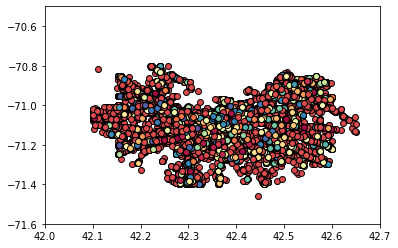

In [23]:
plt.xlim(42,42.7)
plt.ylim(-71.6,-70.5)
for i in range(0,len(labels)):
    if(labels[i] == -1):
       c = [0,0,0,1]
    c = colors[labels[i]]
    x = df_location.iloc(0)[i]['latitude']
    y = df_location.iloc(0)[i]['longitude']
    plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')

Generate list of dataframe, each containing a cluster

In [45]:
cluster_list = [None] * (len(set(labels))-1)
for i in range(0,len(labels)):
    index = labels[i]
    if index != -1:
        if cluster_list[index] == None:
            cluster_list[index] = []
            cluster_list[index].append(df_cluster.iloc(0)[i])
        else:
            cluster_list[index].append(df_cluster.iloc(0)[i])

In [47]:
for i in range(0, len(cluster_list)):
    df_new = pd.DataFrame(cluster_list[i])
    cluster_list[i] = df_new

In [26]:
t = np.array(cluster_list[0]['categories']).tolist()

In [27]:
for i in range(0,len(t)):
    text = t[i]
    t[i] = [x.strip() for x in text.split(',')]


In [28]:
unique_categories = list(set(i for j in t for i in j))
df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)

In [29]:
for i in range(0,len(t)):
    for each in t[i]:
        df_test.loc[i,each] = each
df_test.loc[0,'Wigs']
df_test.isnull().values.any()
df_test
df_test.shape

(3, 17)

In [30]:
while(df_test.isnull().values.any()==True):
    df_test.fillna(str(random.random() * 10000),inplace=True,limit=1)

In [31]:
km = KModes(n_clusters=50, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(df_test)

AssertionError: Cannot have more clusters (50) than data points (3).

In [32]:
l = [None] * len(set(clusters))
for i in range(0,len(clusters)):
    index = clusters[i]
    if index != -1:
        if l[index] == None:
            l[index] = []
            l[index].append(cluster_list[0].iloc(0)[i])
        else:
            l[index].append(cluster_list[0].iloc(0)[i])


NameError: name 'clusters' is not defined

## Clustering for each location cluster

The result is expected to be a list, with each element as a list of clusters. 

In [51]:
res = []
for i in range(0,len(cluster_list)):
    print("%d run:" %(i))
    t = np.array(cluster_list[i]['categories']).tolist()
    for j in range(0,len(t)):
        text = t[j]
        if(text == None):
            text = 'None'
        t[j] = [x.strip() for x in text.split(',')]
    unique_categories = list(set(k for j in t for k in j))
    df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)
    for j in range(0,len(t)):
        for each in t[j]:
            df_test.loc[j,each] = 1/len(t[j])
        df_test.fillna(0,inplace=True)
    km = KMeans(n_clusters=int(min(df_test.shape[0]/4+1,50)),verbose=1).fit(df_test)
    clusters = km.labels_
    l = [None] * len(set(clusters))
    for j in range(0,len(clusters)):
        index = clusters[j]
        if index != -1:
            if l[index] == None:
                l[index] = []
                l[index].append(cluster_list[i].iloc(0)[j])
            else:
                l[index].append(cluster_list[i].iloc(0)[j])
    res.append(l)

0 run:
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, ine

Initialization complete
Iteration 0, inertia 12.79384920634921
Iteration 1, inertia 8.255073979591836
Iteration 2, inertia 8.16470990803729
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.333948412698412
Iteration 1, inertia 8.361741944665335
Iteration 2, inertia 8.305276560740847
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.528106575963722
Iteration 1, inertia 8.414064200680272
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13.851459750566896
Iteration 1, inertia 8.463961268898311
Iteration 2, inertia 8.431987827538423
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.995884353741497
Iteration 1, inertia 8.088929452919276
Iteration 2, inertia 7.975600030862017
Iteration 3, inertia 7.9244885361552
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13.211876417233563


Iteration 0, inertia 1.5
Iteration 1, inertia 0.8333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.9166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.9166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.9166666666666667
Converged at iteration 1: strict convergence.
10 run:
Initialization complete
Iteration 0, inertia 8.124448144448145
Iteration 1, inertia 5.79339191300031
Iteration 2, inertia 5.716082268547148
Iteration 3, inertia 5.691774662727042
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8.635616605616605
Iteration 1, inertia 5.993193726247298
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.60976800976

Initialization complete
Iteration 0, inertia 681.2896435787586
Iteration 1, inertia 502.468729988816
Iteration 2, inertia 482.62616276713027
Iteration 3, inertia 478.9190947883477
Iteration 4, inertia 476.1126659215734
Iteration 5, inertia 472.91370089300597
Iteration 6, inertia 471.5930494168191
Iteration 7, inertia 469.7951602686025
Iteration 8, inertia 468.1363531973738
Iteration 9, inertia 466.2810104885358
Iteration 10, inertia 465.7328523606801
Iteration 11, inertia 465.4558129444696
Iteration 12, inertia 465.4034507912119
Iteration 13, inertia 465.3560640595378
Iteration 14, inertia 465.34902246713204
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 711.7636847071122
Iteration 1, inertia 503.1966579793541
Iteration 2, inertia 486.8643441966437
Iteration 3, inertia 478.1577064340255
Iteration 4, inertia 471.09004573107853
Iteration 5, inertia 469.23387537071716
Iteration 6, inertia 467.91366643295834
Iteration 7, inertia 466.918050985555

Initialization complete
Iteration 0, inertia 40.93621993526755
Iteration 1, inertia 27.5557145467072
Iteration 2, inertia 27.075182688453662
Iteration 3, inertia 26.874436608744087
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 41.2853379028379
Iteration 1, inertia 28.340440839922717
Iteration 2, inertia 27.651162415678588
Iteration 3, inertia 27.507099769857913
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 40.425339085517656
Iteration 1, inertia 28.789705486117033
Iteration 2, inertia 27.863715900684483
Iteration 3, inertia 27.56709906687169
Iteration 4, inertia 27.51906721116127
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 39.5102675895533
Iteration 1, inertia 29.30714296454902
Iteration 2, inertia 28.83229711716961
Iteration 3, inertia 28.672147396451564
Iteration 4, inertia 28.55909447995338
Iteration 5, inertia 28.506845975155823
Iteration 6, inert

Initialization complete
Iteration 0, inertia 23.280563213442004
Iteration 1, inertia 16.072231524077083
Iteration 2, inertia 15.992542598917987
Iteration 3, inertia 15.97370560978367
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 22.927058215153455
Iteration 1, inertia 16.161623288178173
Iteration 2, inertia 15.762696976649258
Iteration 3, inertia 15.664946168476357
Iteration 4, inertia 15.591303947980474
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 23.837895625098007
Iteration 1, inertia 16.83180617112993
Iteration 2, inertia 16.54599401217257
Iteration 3, inertia 16.206003412463986
Iteration 4, inertia 16.129690340951825
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 23.70175788717455
Iteration 1, inertia 16.587675841258076
Iteration 2, inertia 16.262837783396133
Iteration 3, inertia 16.16720726738863
Iteration 4, inertia 16.119672204826408
Iteration 5

Initialization complete
Iteration 0, inertia 25.794268852840275
Iteration 1, inertia 17.2323790424943
Iteration 2, inertia 16.858439750708527
Iteration 3, inertia 16.841403601122988
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 26.19627042269899
Iteration 1, inertia 17.489120045116493
Iteration 2, inertia 17.226359601251854
Iteration 3, inertia 17.13926844296104
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 26.27387958602244
Iteration 1, inertia 17.3868569355596
Iteration 2, inertia 17.144443588079014
Iteration 3, inertia 16.972829155419277
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 26.164493502529215
Iteration 1, inertia 17.98671133743284
Iteration 2, inertia 17.254929943391417
Iteration 3, inertia 17.08811490606689
Iteration 4, inertia 17.06260907974301
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 26.65

Iteration 0, inertia 1.9472789115646258
Iteration 1, inertia 1.090249433106576
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6944444444444442
Iteration 1, inertia 1.0401549508692367
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.812358276643991
Iteration 1, inertia 1.0401549508692367
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8044217687074828
Iteration 1, inertia 1.090249433106576
Converged at iteration 1: strict convergence.
33 run:
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 1.05
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 1.05
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 1.05
Converged at iteration 1: strict convergence.
Initializat

Initialization complete
Iteration 0, inertia 7.11031746031746
Iteration 1, inertia 4.67818783068783
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.3861904761904755
Iteration 1, inertia 4.925405338837621
Iteration 2, inertia 4.782623614260519
Iteration 3, inertia 4.7100140763997915
Iteration 4, inertia 4.658230856445142
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 7.810476190476191
Iteration 1, inertia 4.597589189064806
Iteration 2, inertia 4.467026927437641
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.749999999999999
Iteration 1, inertia 4.663853500996358
Iteration 2, inertia 4.562843399986256
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.781009070294784
Iteration 1, inertia 4.568581840813927
Iteration 2, inertia 4.535616026587001
Iteration 3, inertia 4.513902613354144
Converged at iteration 3: strict 

Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.4666666666666667.
Conver

Initialization complete
Iteration 0, inertia 6.608399470899471
Iteration 1, inertia 4.375693721064814
Iteration 2, inertia 4.3015332577475425
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.514880952380953
Iteration 1, inertia 4.162208994708995
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.982308201058201
Iteration 1, inertia 4.95711262282691
Iteration 2, inertia 4.9266864516804425
Iteration 3, inertia 4.894482473544974
Iteration 4, inertia 4.84349506974507
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 6.463130511463845
Iteration 1, inertia 4.481692019400352
Iteration 2, inertia 4.458273849607183
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.749426807760143
Iteration 1, inertia 4.451138252008622
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.2389880952380965
I

Initialization complete
Iteration 0, inertia 27.244490456633308
Iteration 1, inertia 18.554626626788938
Iteration 2, inertia 18.42752812422603
Iteration 3, inertia 18.41682240378669
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 27.114411976911974
Iteration 1, inertia 18.973093468470122
Iteration 2, inertia 18.290685191080517
Iteration 3, inertia 18.074808237324667
Iteration 4, inertia 18.04246090986349
Iteration 5, inertia 18.00479417230238
Iteration 6, inertia 17.9831194749506
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 27.565559995559997
Iteration 1, inertia 18.971917927725414
Iteration 2, inertia 18.328475838031707
Iteration 3, inertia 18.31165687964914
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 26.06039765789766
Iteration 1, inertia 18.276166484427034
Iteration 2, inertia 18.088395819362887
Iteration 3, inertia 18.063271744239003
Converged at i

Iteration 0, inertia 5.868571428571428
Iteration 1, inertia 3.3474819624819627
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.465873015873017
Iteration 1, inertia 3.42110582010582
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.406349206349207
Iteration 1, inertia 3.7355467372134044
Converged at iteration 1: strict convergence.
62 run:
Initialization complete
Iteration 0, inertia 3.7055555555555557
Iteration 1, inertia 2.5274074074074075
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8388888888888886
Iteration 1, inertia 2.390740740740741
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8944444444444444
Iteration 1, inertia 2.276666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9055555555555563
Iteration 1, inertia 2.426388888888889
Converged at iterati

Iteration 0, inertia 13.48887755102041
Iteration 1, inertia 8.666272418058131
Iteration 2, inertia 8.549170011337868
Iteration 3, inertia 8.271242476414434
Iteration 4, inertia 8.117664994569257
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12.936201814058958
Iteration 1, inertia 8.149749433106575
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13.271462585034012
Iteration 1, inertia 8.288442188014805
Iteration 2, inertia 8.202605006105006
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.508707482993199
Iteration 1, inertia 8.70959651585502
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 12.838662131519275
Iteration 1, inertia 8.088437972411187
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 12.726122448979588
Iteration 1, inertia 8.068510632001184
Iteration 2, inertia 8

Initialization complete
Iteration 0, inertia 16.071525888133035
Iteration 1, inertia 10.888587995010141
Iteration 2, inertia 10.839727562499908
Iteration 3, inertia 10.727258960065509
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 16.146481481481484
Iteration 1, inertia 10.96555869371558
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16.772499999999997
Iteration 1, inertia 11.324759563457013
Iteration 2, inertia 11.080022069475937
Iteration 3, inertia 11.043461737489212
Iteration 4, inertia 11.020364660464544
Iteration 5, inertia 10.99793537414966
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16.007709750566896
Iteration 1, inertia 10.908260880347616
Iteration 2, inertia 10.66313794430092
Iteration 3, inertia 10.48486585820311
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15.159285714285717
Iteration 1, inertia

Initialization complete
Iteration 0, inertia 18.705555555555556
Iteration 1, inertia 12.338279021044043
Iteration 2, inertia 12.251466733663161
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.77956349206349
Iteration 1, inertia 11.479646825396824
Iteration 2, inertia 11.086916514041512
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.53253968253968
Iteration 1, inertia 12.139765873015872
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 18.345158730158733
Iteration 1, inertia 11.573590316952805
Iteration 2, inertia 11.460044134106631
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.88589947089947
Iteration 1, inertia 11.713387011575158
Iteration 2, inertia 11.436438054856024
Iteration 3, inertia 11.358568104734772
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 17.93920

Initialization complete
Iteration 0, inertia 11.95511063011063
Iteration 1, inertia 7.931355572115252
Iteration 2, inertia 7.811275327450257
Iteration 3, inertia 7.7920625619236725
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11.87135642135642
Iteration 1, inertia 7.783993799265739
Iteration 2, inertia 7.759381313131312
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.697474747474747
Iteration 1, inertia 7.812951030142696
Iteration 2, inertia 7.667820483271872
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.954058441558441
Iteration 1, inertia 7.75708046069157
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 11.747268318101654
Iteration 1, inertia 8.015589940409384
Iteration 2, inertia 7.950745101325909
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.52929894179894

Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375.
Converged at iteration 1: strict convergence.
91 run:
Initialization complete
Iteration 0, inertia 82.17319791552984
Iteration 1, inertia 56.267182711241965
Iteration 2, inertia 54.478798177634815
Iteration 3, inertia 53.88509177590174
Iteration 4, inertia 53.61311537054996
Iteration 5, inertia 53.41988608867322
Iteration 6, inertia 53.40272589423114
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 82.0919956701689
Iteration 1, inertia 56.765572213481725
Iteration 2, inertia 55.08356910217277
Iteration 3, inertia 54.84222988221375
Iteration 4, inertia 54.81699830475672
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 80.9888953123337
Iteration 1, inertia 56.41503510189703
Iteration 2, inertia 54.78081569839363
Iteration 

Initialization complete
Iteration 0, inertia 18.84144766569009
Iteration 1, inertia 12.851513133961596
Iteration 2, inertia 12.542829485401787
Iteration 3, inertia 12.46869810526797
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 18.752997288906382
Iteration 1, inertia 12.140003231152614
Iteration 2, inertia 12.036097801795083
Iteration 3, inertia 12.007578748589275
Iteration 4, inertia 11.956072370243026
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 20.604740259740264
Iteration 1, inertia 12.328493900562734
Iteration 2, inertia 12.138232184669054
Iteration 3, inertia 12.082086712389744
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 18.588886338128766
Iteration 1, inertia 12.489203357043255
Iteration 2, inertia 12.357797209614581
Iteration 3, inertia 12.287944585256813
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inert

Initialization complete
Iteration 0, inertia 20.082420634920634
Iteration 1, inertia 13.311759357095893
Iteration 2, inertia 13.265572116078177
Iteration 3, inertia 13.249959656084654
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 20.636845238095237
Iteration 1, inertia 13.550610014486232
Iteration 2, inertia 13.266882247240073
Iteration 3, inertia 13.016758613523514
Iteration 4, inertia 12.897298338851101
Iteration 5, inertia 12.87482920760897
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 20.078928571428573
Iteration 1, inertia 13.37312103174603
Iteration 2, inertia 13.346037698412701
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 21.29296296296296
Iteration 1, inertia 14.095677253372726
Iteration 2, inertia 13.923918558530449
Iteration 3, inertia 13.860534342471302
Iteration 4, inertia 13.833797398180051
Converged at iteration 4: strict convergence.
Ini

Iteration 3, inertia 5.444036053893196
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8.408470695970696
Iteration 1, inertia 5.597466404296762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.73812604723319
Iteration 1, inertia 5.256431592358889
Iteration 2, inertia 5.22066132280418
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.537213348820492
Iteration 1, inertia 5.580419214005948
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.771495171495172
Iteration 1, inertia 5.7918287740616545
Iteration 2, inertia 5.709002207778994
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.765469252969252
Iteration 1, inertia 5.67831110649388
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.222070389927532
Iteration 1, inertia 5.4307447507240

Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.416666

Initialization complete
Iteration 0, inertia 36.14430877654092
Iteration 1, inertia 24.882518230358816
Iteration 2, inertia 24.404659971879113
Iteration 3, inertia 24.305956421627663
Iteration 4, inertia 24.27542447403381
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 37.0415241273277
Iteration 1, inertia 25.412894820933033
Iteration 2, inertia 24.778496084834046
Iteration 3, inertia 24.53061239730217
Iteration 4, inertia 24.456564489682126
Iteration 5, inertia 24.41416702952826
Iteration 6, inertia 24.391954900552737
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 36.65500120250121
Iteration 1, inertia 24.920237188956655
Iteration 2, inertia 24.442508342755588
Iteration 3, inertia 24.26228551500375
Iteration 4, inertia 24.1928020193427
Iteration 5, inertia 24.15470652690299
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 37.57976525458669
Iteration 1, inert

122 run:
Initialization complete
Iteration 0, inertia 8.956437754165027
Iteration 1, inertia 6.1110176549040185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.702469500196772
Iteration 1, inertia 6.083090006434163
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.545831693558966
Iteration 1, inertia 6.713563276550288
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.790853338580611
Iteration 1, inertia 6.2916067988260505
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.68125737898465
Iteration 1, inertia 6.1380273350387
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.690348288075558
Iteration 1, inertia 6.219607601993967
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.03926603699331
Iteration 1, inertia 6.2406743646619685
Co

Initialization complete
Iteration 0, inertia 14.826192220477935
Iteration 1, inertia 9.99677248320418
Iteration 2, inertia 9.696720573579658
Iteration 3, inertia 9.647042409754045
Iteration 4, inertia 9.634713332137439
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14.948595848595847
Iteration 1, inertia 9.879264356008363
Iteration 2, inertia 9.775345941652331
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.37329822954823
Iteration 1, inertia 10.118633584613976
Iteration 2, inertia 9.825718001283255
Iteration 3, inertia 9.648452742615158
Iteration 4, inertia 9.632600946763903
Iteration 5, inertia 9.564738410871065
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15.475122972265828
Iteration 1, inertia 10.354184353203134
Iteration 2, inertia 10.200120497301052
Iteration 3, inertia 10.165338860077027
Iteration 4, inertia 10.148227416873253
Converged at itera

Initialization complete
Iteration 0, inertia 1.2
Iteration 1, inertia 0.5666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000001
Iteration 1, inertia 0.7444444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.7916666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333332
Iteration 1, inertia 0.5666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000001
Iteration 1, inertia 0.7444444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.8166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.8166666666666667
Converged a

142 run:
Initialization complete
Iteration 0, inertia 5.2243518518518535
Iteration 1, inertia 3.4064164462081137
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.985052910052911
Iteration 1, inertia 3.480246913580246
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.750446428571429
Iteration 1, inertia 3.4193119149369147
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.0695899470899475
Iteration 1, inertia 3.229733401920439
Iteration 2, inertia 3.181289269179894
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.293055555555555
Iteration 1, inertia 3.4294761904761906
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.9622354497354495
Iteration 1, inertia 3.2488640976355825
Iteration 2, inertia 3.204517563198119
Converged at iteration 2: strict convergence.
Initialization com

Initialization complete
Iteration 0, inertia 4.253968253968254
Iteration 1, inertia 2.3083900226757375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.880952380952381
Iteration 1, inertia 2.3083900226757375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.2063492063492065
Iteration 1, inertia 2.1968253968253966
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.285714285714286
Iteration 1, inertia 2.2341269841269837
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.678571428571428
Iteration 1, inertia 2.2341269841269837
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.73015873015873
Iteration 1, inertia 2.3677248677248683
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.78968253968254
Iteration 1, inertia 2.306150793650794
Conve

Iteration 2, inertia 5.155744520030234
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.714880952380953
Iteration 1, inertia 5.0361252834467125
Iteration 2, inertia 4.873377267573696
Iteration 3, inertia 4.832503779289493
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8.091071428571428
Iteration 1, inertia 4.9529265873015875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.841071428571429
Iteration 1, inertia 5.490786210317461
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.927040816326532
Iteration 1, inertia 5.083531071158623
Iteration 2, inertia 4.992261229888781
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.736904761904762
Iteration 1, inertia 5.945250496031746
Converged at iteration 1: strict convergence.
155 run:
Initialization complete
Iteration 0, inertia 1.

Iteration 1, inertia 2.484259259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.350000000000001
Iteration 1, inertia 2.56875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.483333333333334
Iteration 1, inertia 2.569444444444445
Converged at iteration 1: strict convergence.
162 run:
Initialization complete
Iteration 0, inertia 13.890530045351472
Iteration 1, inertia 8.964024928216542
Iteration 2, inertia 8.782691240208205
Iteration 3, inertia 8.698405129097093
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14.330351473922901
Iteration 1, inertia 9.050137113113644
Iteration 2, inertia 8.99938321300141
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 14.346103896103898
Iteration 1, inertia 8.667427443177798
Iteration 2, inertia 8.600281004489336
Converged at iteration 2: strict convergence.
Initialization com

Initialization complete
Iteration 0, inertia 4.993650793650795
Iteration 1, inertia 3.1796031746031748
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.198809523809524
Iteration 1, inertia 3.069036596119929
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.5813492063492065
Iteration 1, inertia 3.1580215419501134
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.596031746031747
Iteration 1, inertia 3.0697235304378157
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.946031746031746
Iteration 1, inertia 3.2108937833296807
Iteration 2, inertia 3.1676965230536656
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.904761904761905
Iteration 1, inertia 3.224051398337113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.635770975056689
Iter

173 run:
Initialization complete
Iteration 0, inertia 5.471190476190477
Iteration 1, inertia 3.2214185681216936
Iteration 2, inertia 3.051333711262282
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.324206349206349
Iteration 1, inertia 3.0392757936507935
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.041666666666666
Iteration 1, inertia 3.1619510582010584
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.793412698412699
Iteration 1, inertia 3.2004087301587307
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.941666666666666
Iteration 1, inertia 3.158547619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.863888888888889
Iteration 1, inertia 3.172714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.5456349206349

Initialization complete
Iteration 0, inertia 7.231904761904763
Iteration 1, inertia 4.905511708798746
Iteration 2, inertia 4.719982259570495
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.832142857142857
Iteration 1, inertia 5.190079365079365
Iteration 2, inertia 5.088822751322751
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.406349206349208
Iteration 1, inertia 4.873125415743639
Iteration 2, inertia 4.7981894841269845
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.968015873015874
Iteration 1, inertia 4.583830589849108
Iteration 2, inertia 4.509687208216619
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.582539682539682
Iteration 1, inertia 4.729558823529412
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.173968253968254
Iteration 1, inertia 5.050188447774943
I

Initialization complete
Iteration 0, inertia 2.625
Iteration 1, inertia 1.21875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 1.1666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.291666666666667
Iteration 1, inertia 1.1166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.625
Iteration 1, inertia 1.1750000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 1.1666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.291666666666667
Iteration 1, inertia 1.1166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.625
Iteration 1, inertia 1.1750000000000003
Converged at iteration 1: strict convergence.
In

Initialization complete
Iteration 0, inertia 19.755582283877736
Iteration 1, inertia 12.719595096879665
Iteration 2, inertia 12.502151232109016
Iteration 3, inertia 12.418348724825066
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 18.46733995281614
Iteration 1, inertia 12.889212834855003
Iteration 2, inertia 12.516340837345941
Iteration 3, inertia 12.479752730289393
Iteration 4, inertia 12.402742877516715
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 19.867287414965986
Iteration 1, inertia 12.692621670880303
Iteration 2, inertia 12.418132306404939
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 19.01084441352299
Iteration 1, inertia 12.497485814698988
Iteration 2, inertia 12.363449733197061
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 18.860071220866672
Iteration 1, inertia 13.217923899696926
Iteration 2, inert

Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.4472222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.4472222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.4472222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6833333333333336
Iteration 1, inertia 1.5338888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5166666666666666
Iteration 1, inertia 1.5993055555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6416666666666666
Iteration 1, inertia 1.641666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7583333333333333
Iteration 1, inertia 1.63750000000000

Initialization complete
Iteration 0, inertia 11.39265306122449
Iteration 1, inertia 7.268313654033043
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.792222222222223
Iteration 1, inertia 7.352613683935113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.869160997732425
Iteration 1, inertia 7.4024000954548494
Iteration 2, inertia 7.350342803788182
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.452097505668934
Iteration 1, inertia 7.953139254220208
Iteration 2, inertia 7.7406787497133935
Iteration 3, inertia 7.7165895348038225
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10.883922902494332
Iteration 1, inertia 7.269220049130764
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.707653061224491
Iteration 1, inertia 7.40667977965597
Converged at iteration 1: strict c

Initialization complete
Iteration 0, inertia 5.391666666666667
Iteration 1, inertia 3.6545861678004545
Iteration 2, inertia 3.5931249999999997
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.322222222222223
Iteration 1, inertia 3.8233670033670037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.436111111111111
Iteration 1, inertia 3.7859567901234574
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.538888888888889
Iteration 1, inertia 3.588055555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.998148148148148
Iteration 1, inertia 3.757208994708995
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.887037037037037
Iteration 1, inertia 3.5807407407407417
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.7027777777777775
Iter

Initialization complete
Iteration 0, inertia 1.6761904761904765
Iteration 1, inertia 0.8909523809523812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1761904761904765
Iteration 1, inertia 0.8909523809523812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1761904761904765
Iteration 1, inertia 0.8909523809523812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6761904761904765
Iteration 1, inertia 0.8909523809523812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6761904761904765
Iteration 1, inertia 0.8909523809523812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6761904761904765
Iteration 1, inertia 0.8909523809523812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1761904761904765
Iteration 1, inertia 0.8909523809523

Iteration 5, inertia 24.924370036492817
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 39.0829226640151
Iteration 1, inertia 27.05544140048356
Iteration 2, inertia 26.466256328845777
Iteration 3, inertia 26.406395432258492
Iteration 4, inertia 26.38232164021161
Iteration 5, inertia 26.35083559948365
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 39.545262746512755
Iteration 1, inertia 26.685900825147666
Iteration 2, inertia 26.048851357077396
Iteration 3, inertia 25.869934264460554
Iteration 4, inertia 25.789910098969216
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 37.944974989996
Iteration 1, inertia 26.883907006356836
Iteration 2, inertia 26.19489273017868
Iteration 3, inertia 26.059154747156867
Iteration 4, inertia 26.035910260064192
Converged at iteration 4: strict convergence.
221 run:
Initialization complete
Iteration 0, inertia 4.076666666666668
I

Initialization complete
Iteration 0, inertia 9.272075517075514
Iteration 1, inertia 6.052038836398758
Iteration 2, inertia 5.636567780641348
Iteration 3, inertia 5.582652150759294
Iteration 4, inertia 5.555439428296572
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 8.967688792688794
Iteration 1, inertia 6.313500063806186
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.972539682539681
Iteration 1, inertia 6.033705341902215
Iteration 2, inertia 5.84375151585579
Iteration 3, inertia 5.804770816419846
Iteration 4, inertia 5.782564258026443
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 8.982193362193362
Iteration 1, inertia 5.943174544767401
Iteration 2, inertia 5.834339292023706
Iteration 3, inertia 5.80468816213354
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9.832647907647909
Iteration 1, inertia 6.009285882492

Initialization complete
Iteration 0, inertia 2.692857142857143
Iteration 1, inertia 1.3977579365079367
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8358730158730165
Iteration 1, inertia 1.7383134920634924
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2923809523809524
Iteration 1, inertia 1.3624391534391533
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.82952380952381
Iteration 1, inertia 1.3728628117913835
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3634920634920635
Iteration 1, inertia 1.3624391534391533
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.692857142857143
Iteration 1, inertia 1.3977579365079367
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5914285714285716
Iteration 1, inertia 1.575777777777778
C

Initialization complete
Iteration 0, inertia 6.584550264550265
Iteration 1, inertia 3.9249223985890658
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.875264550264551
Iteration 1, inertia 4.063305485937065
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.7939153439153435
Iteration 1, inertia 4.28855796055796
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.283624338624338
Iteration 1, inertia 4.039465608465609
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.361031746031747
Iteration 1, inertia 4.0426207010582
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.088624338624338
Iteration 1, inertia 3.8798532113462665
Iteration 2, inertia 3.8011199294532627
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.526216931216932
Iteration

Iteration 1, inertia 1.375.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5.
Iteration 1, inertia 1.375.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1666666666666665.
Iteration 1, inertia 1.375.
Converged at iteration 1: strict convergence.
246 run:
Initialization complete
Iteration 0, inertia 2.2444444444444445
Iteration 1, inertia 1.465079365079365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4444444444444446
Iteration 1, inertia 1.7361111111111107
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.327777777777778
Iteration 1, inertia 1.5376984126984126
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.05
Iteration 1, inertia 1.2731481481481484
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.583333333333333
Iterati

Initialization complete
Iteration 0, inertia 11.857119599976743
Iteration 1, inertia 7.674445454446872
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 12.198430141287286
Iteration 1, inertia 8.340547208615165
Iteration 2, inertia 8.286284808167604
Iteration 3, inertia 8.260446710023041
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12.555003052503052
Iteration 1, inertia 8.173183200936354
Iteration 2, inertia 7.8923731317183705
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.121611721611721
Iteration 1, inertia 7.764526971976606
Iteration 2, inertia 7.67991158736122
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.497953950811093
Iteration 1, inertia 7.848259693514157
Iteration 2, inertia 7.780607248241177
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.914100383743

Initialization complete
Iteration 0, inertia 3.2166666666666663
Iteration 1, inertia 1.7586111111111113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5277777777777777
Iteration 1, inertia 1.7586111111111113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.627777777777778
Iteration 1, inertia 2.088888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3611111111111107
Iteration 1, inertia 1.825925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2666666666666666
Iteration 1, inertia 2.118055555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.683333333333333
Iteration 1, inertia 1.8402777777777775
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3277777777777775
Iteration 1, inertia 1.7586111111111113
C

Iteration 0, inertia 2.216666666666667
Iteration 1, inertia 1.225
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333333
Iteration 1, inertia 1.0847222222222221
Converged at iteration 1: strict convergence.
264 run:
Initialization complete
Iteration 0, inertia 7.204081632653061
Iteration 1, inertia 4.1993849206349205
Iteration 2, inertia 4.138656462585034
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.991666666666665
Iteration 1, inertia 4.213519536019536
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.60376984126984
Iteration 1, inertia 4.315826792255364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.781547619047619
Iteration 1, inertia 4.287851821000509
Iteration 2, inertia 4.2084827727387255
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.581462585034

Initialization complete
Iteration 0, inertia 14.782845804988664
Iteration 1, inertia 9.305885428339472
Iteration 2, inertia 9.222738195227299
Iteration 3, inertia 9.095141914397015
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13.526757369614515
Iteration 1, inertia 8.913093551477877
Iteration 2, inertia 8.642658690791132
Iteration 3, inertia 8.588162589987617
Iteration 4, inertia 8.560996598687264
Iteration 5, inertia 8.529468549112766
Iteration 6, inertia 8.503744047619048
Iteration 7, inertia 8.473674774734455
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 13.65345238095238
Iteration 1, inertia 9.177331511081512
Iteration 2, inertia 9.093415427165427
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 14.350912698412701
Iteration 1, inertia 8.912675878684807
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13.936984

Initialization complete
Iteration 0, inertia 15.134603174603173
Iteration 1, inertia 9.463092159676348
Iteration 2, inertia 9.356764914216836
Iteration 3, inertia 9.30303020282187
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14.771058201058203
Iteration 1, inertia 9.623766143882307
Iteration 2, inertia 9.516399128963753
Iteration 3, inertia 9.482378394092681
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15.089656084656085
Iteration 1, inertia 10.3606758743034
Iteration 2, inertia 10.121341209716206
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.926084656084656
Iteration 1, inertia 10.251362752739984
Iteration 2, inertia 10.106290721844292
Iteration 3, inertia 10.086512973137973
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15.656798941798945
Iteration 1, inertia 9.952474650302932
Iteration 2, inertia 9.861

Iteration 1, inertia 2.554951025405571
Converged at iteration 1: strict convergence.
281 run:
Initialization complete
Iteration 0, inertia 3.581660561660562
Iteration 1, inertia 2.170683760683761
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2410256410256415
Iteration 1, inertia 1.9814607614607616
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4246092796092795
Iteration 1, inertia 1.9701620601620606
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9588827838827845
Iteration 1, inertia 2.0695228130455408
Iteration 2, inertia 2.0161575091575092
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.045512820512821
Iteration 1, inertia 2.2614607614607616
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5005494505494514
Iteration 1, inertia 2.212485292485293
Converged at ite

Initialization complete
Iteration 0, inertia 6.311373626373627
Iteration 1, inertia 4.028500915750916
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.216135531135532
Iteration 1, inertia 3.891349206349206
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.311373626373627
Iteration 1, inertia 4.028500915750916
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.399725274725274
Iteration 1, inertia 4.793936275364846
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.889768009768011
Iteration 1, inertia 4.027277370777371
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.083180708180709
Iteration 1, inertia 3.9332979242979245
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.629212454212453
Iteration 1, inertia 4.122912087912088
Converged

Iteration 1, inertia 2.893528693528693
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.723809523809523
Iteration 1, inertia 3.023941798941799
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.093650793650794
Iteration 1, inertia 2.9478021978021975
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.288095238095239
Iteration 1, inertia 2.9487433862433856
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.396825396825397
Iteration 1, inertia 2.8643915343915336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.3121693121693125
Iteration 1, inertia 2.979100529100529
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.223280423280423
Iteration 1, inertia 2.9256834215167546
Converged at iteration 1: strict convergence.
Initialization complet

Initialization complete
Iteration 0, inertia 3.067460317460317
Iteration 1, inertia 1.734441924918115
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8928571428571423
Iteration 1, inertia 1.6070011337868482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9126984126984126
Iteration 1, inertia 1.6070011337868482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8698979591836733
Iteration 1, inertia 1.7146006550768451
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.976190476190476
Iteration 1, inertia 1.774990551776266
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.964285714285714
Iteration 1, inertia 1.734441924918115
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9761904761904763
Iteration 1, inertia 1.7146006550768451
Co

Initialization complete
Iteration 0, inertia 14.639920634920635
Iteration 1, inertia 10.24027040887904
Iteration 2, inertia 10.058188824734323
Iteration 3, inertia 9.863523619565532
Iteration 4, inertia 9.81244932408861
Iteration 5, inertia 9.78177266314218
Iteration 6, inertia 9.751222348198537
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15.659718614718615
Iteration 1, inertia 10.129005540094825
Iteration 2, inertia 10.100808605748835
Iteration 3, inertia 10.054908738748024
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14.778653885796743
Iteration 1, inertia 9.805796725761013
Iteration 2, inertia 9.75390541182803
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.528982683982683
Iteration 1, inertia 10.080643827733113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 15.119447536590393
Iteration 1, inertia 9.887

Initialization complete
Iteration 0, inertia 3.6349206349206344
Iteration 1, inertia 1.9240362811791385
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.426190476190476
Iteration 1, inertia 1.9240362811791385
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.737301587301587
Iteration 1, inertia 2.0965277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6349206349206344
Iteration 1, inertia 1.9240362811791385
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8611111111111107
Iteration 1, inertia 2.0861111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.476190476190476
Iteration 1, inertia 1.993650793650794
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5595238095238098
Iteration 1, inertia 2.000132275132275
C

Initialization complete
Iteration 0, inertia 2.3833333333333337
Iteration 1, inertia 1.4954166666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.612222222222223
Iteration 1, inertia 1.354074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.272222222222222
Iteration 1, inertia 1.5252777777777782
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5788888888888892
Iteration 1, inertia 1.3657222222222225
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.692222222222223
Iteration 1, inertia 1.354074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7788888888888894
Iteration 1, inertia 1.4011111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.687777777777778
Iteration 1, inertia 1.4011111111111112
Co

Initialization complete
Iteration 0, inertia 3.7535714285714286
Iteration 1, inertia 2.0548611111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1982142857142857
Iteration 1, inertia 2.305073696145125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3728174603174605
Iteration 1, inertia 2.052295918367347
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1345238095238095
Iteration 1, inertia 2.3236331569664905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.396428571428572
Iteration 1, inertia 2.544091710758378
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.662301587301587
Iteration 1, inertia 2.153353174603174
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7349206349206345
Iteration 1, inertia 2.2021164021164017
Co

Iteration 0, inertia 2.2916666666666665
Iteration 1, inertia 1.2615740740740742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.361111111111111
Iteration 1, inertia 1.1770833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.444444444444444
Iteration 1, inertia 1.2199074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2083333333333335
Iteration 1, inertia 1.2847222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.361111111111111
Iteration 1, inertia 1.1770833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.361111111111111
Iteration 1, inertia 1.1770833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.361111111111111
Iteration 1, inertia 1.1770833333333335
Converged at iteration 1:

Iteration 0, inertia 6.956349206349205
Iteration 1, inertia 4.287425595238095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.717460317460316
Iteration 1, inertia 4.222871231332769
Iteration 2, inertia 4.167205215419501
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.894047619047619
Iteration 1, inertia 4.112599206349206
Converged at iteration 1: strict convergence.
336 run:
Initialization complete
Iteration 0, inertia 1.357777777777778
Iteration 1, inertia 0.9374074074074075
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4466666666666668
Iteration 1, inertia 0.9126666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.157777777777778
Iteration 1, inertia 0.8337037037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.357777777777778
Iteration 1, inertia 

Initialization complete
Iteration 0, inertia 6.587891737891736
Iteration 1, inertia 4.440107312440645
Iteration 2, inertia 4.39150345869592
Iteration 3, inertia 4.353946581196581
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 7.050142450142451
Iteration 1, inertia 4.378808315527064
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.99852207977208
Iteration 1, inertia 4.157999960430517
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.217329059829059
Iteration 1, inertia 4.11971589110478
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.89227564102564
Iteration 1, inertia 4.096050094966762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.576495726495726
Iteration 1, inertia 4.615600325600326
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, i

Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4250000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.825.
Iteration 1, inertia 0.4250000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4250000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.825.
Iteration 1, inertia 0.4250000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.825.
Iteration 1, inertia 0.4250000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.825.
Iteration 1, inertia 0.4250000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4250000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Iteration 1, inertia 1.9897959183673468
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.292857142857143
Iteration 1, inertia 1.9517006802721089
Converged at iteration 1: strict convergence.
355 run:
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7083333333333335.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7916666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7916666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7083333333333335.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict conv

Initialization complete
Iteration 0, inertia 1.1428571428571428
Iteration 1, inertia 0.49999999999999994
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0238095238095237
Iteration 1, inertia 0.5357142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.5625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5694444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.5625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809524
Iteration 1, inertia 0.5714285714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.5357142857142857
Converged at iteration 1: strict convergence.
I

Initialization complete
Iteration 0, inertia 3.0297619047619047
Iteration 1, inertia 1.8762755102040813
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8851190476190474
Iteration 1, inertia 1.8354960317460318
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.939285714285714
Iteration 1, inertia 1.693062641723356
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9821428571428568
Iteration 1, inertia 1.771031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2327380952380955
Iteration 1, inertia 1.8037202380952382
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.813690476190476
Iteration 1, inertia 1.7683531746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.026190476190476
Iteration 1, inertia 1.877810846560847
Co

Initialization complete
Iteration 0, inertia 8.474747474747474
Iteration 1, inertia 4.643801707551708
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.871969696969697
Iteration 1, inertia 5.187671824806311
Iteration 2, inertia 5.1559020763187435
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.8121212121212125
Iteration 1, inertia 4.556642817059483
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.138030303030304
Iteration 1, inertia 4.820828861531987
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.314709595959595
Iteration 1, inertia 4.689834084896585
Iteration 2, inertia 4.660851316192225
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.733080808080808
Iteration 1, inertia 4.7824583333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iterati

Iteration 1, inertia 0.23809523809523808.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.23809523809523808.
Converged at iteration 1: strict convergence.
382 run:
Initialization complete
Iteration 0, inertia 5.461904761904763
Iteration 1, inertia 3.665911152339723
Iteration 2, inertia 3.5371232735518454
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.91952380952381
Iteration 1, inertia 3.660689342403628
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.015646258503401
Iteration 1, inertia 3.6266060862214706
Iteration 2, inertia 3.528010204081632
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.18095238095238
Iteration 1, inertia 3.6150736961451244
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.798639455782313
Iteration 1, inertia 3.43724651

Initialization complete
Iteration 0, inertia 8.552596371882085
Iteration 1, inertia 5.308233887629126
Iteration 2, inertia 5.2284845049130775
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.53950113378685
Iteration 1, inertia 5.321252362055934
Converged at iteration 1: strict convergence.
388 run:
Initialization complete
Iteration 0, inertia 2.4226190476190474
Iteration 1, inertia 1.5332745443856552
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.372883597883598
Iteration 1, inertia 1.6586934156378599
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9006613756613757
Iteration 1, inertia 1.3041078777189887
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.449404761904762
Iteration 1, inertia 1.4279572940287226
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.67361111111

Iteration 1, inertia 3.783034391534392
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.822222222222222
Iteration 1, inertia 3.76452380952381
Converged at iteration 1: strict convergence.
395 run:
Initialization complete
Iteration 0, inertia 5.511791383219955
Iteration 1, inertia 3.44234693877551
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.3192743764172326
Iteration 1, inertia 3.2789527932385076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.591269841269841
Iteration 1, inertia 3.1805744520030235
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.3808390022675745
Iteration 1, inertia 3.0487981859410422
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.56689342403628
Iteration 1, inertia 3.2929600235155796
Iteration 2, inertia 3.2179421768707486
Converged at iteratio

Initialization complete
Iteration 0, inertia 3.6942857142857153
Iteration 1, inertia 2.4132390873015868
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.739523809523809
Iteration 1, inertia 2.258287037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.430595238095238
Iteration 1, inertia 2.458561507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5595238095238098
Iteration 1, inertia 2.274033882783883
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.859523809523809
Iteration 1, inertia 2.229953703703704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9160119047619055
Iteration 1, inertia 2.637643849206349
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.007380952380952
Iteration 1, inertia 2.2748214285714288
Conve

Initialization complete
Iteration 0, inertia 3.1607709750566895
Iteration 1, inertia 1.8195672713529856
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.87108843537415
Iteration 1, inertia 1.6567913832199546
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9531746031746033
Iteration 1, inertia 1.6508578987150417
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.663151927437642
Iteration 1, inertia 1.710341080876795
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.869047619047619
Iteration 1, inertia 1.6909722222222217
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.94047619047619
Iteration 1, inertia 1.6751558956916095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1468253968253976
Iteration 1, inertia 1.683489229024943
Conv

Iteration 0, inertia 3.2157142857142857
Iteration 1, inertia 2.0116096230158726
Iteration 2, inertia 1.8901700680272107
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.499047619047619
Iteration 1, inertia 2.2318119047619045
Iteration 2, inertia 2.1576984126984122
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.084761904761905
Iteration 1, inertia 1.9545714285714288
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.97047619047619
Iteration 1, inertia 1.9780952380952381
Converged at iteration 1: strict convergence.
415 run:
Initialization complete
Iteration 0, inertia 1.8873015873015873
Iteration 1, inertia 1.233015873015873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1142857142857143
Iteration 1, inertia 1.1882086167800454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, ine

Initialization complete
Iteration 0, inertia 5.886666666666667
Iteration 1, inertia 3.8492962962962967
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.183333333333334
Iteration 1, inertia 3.6179797979797974
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.67
Iteration 1, inertia 3.6321825396825407
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.775
Iteration 1, inertia 3.519197530864198
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.936666666666667
Iteration 1, inertia 3.75537037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.386666666666668
Iteration 1, inertia 3.452277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.677777777777778
Iteration 1, inertia 3.631250000000001
Converged at iteration 1: strict 

Iteration 0, inertia 0.7380952380952381
Iteration 1, inertia 0.4305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222223
Iteration 1, inertia 0.4305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7380952380952381
Iteration 1, inertia 0.4305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142858
Iteration 1, inertia 0.4305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222
Iteration 1, inertia 0.4305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222223
Iteration 1, inertia 0.4305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222
Iteration 1, inertia 0.4305555555555556
Converged at iterati

Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9500000000000002.
Iteration 1, inertia 0.8125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9500000000000002.
Iteration 1, inertia 0.8125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8125.
Converged at iteration 1: strict convergence.
437 run:
Initialization complete
Iteration 0, inertia 7.198148148148149
Iteration 1, inertia 5.391172839506173
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.716666666666668
Iteration 1, inertia 4.977136752136753
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.216666666666667
Iteration 1, inertia 4.759567901234568
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, in

Iteration 0, inertia 7.816269841269841
Iteration 1, inertia 5.30942485181207
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.664351851851851
Iteration 1, inertia 4.881282596371881
Converged at iteration 1: strict convergence.
443 run:
Initialization complete
Iteration 0, inertia 1.366666666666667
Iteration 1, inertia 0.78
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333337
Iteration 1, inertia 0.675
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666667
Iteration 1, inertia 0.78
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333337
Iteration 1, inertia 0.675
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.216666666666667
Iteration 1, inertia 0.675
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, in

Iteration 0, inertia 4.483333333333333
Iteration 1, inertia 2.463412698412698
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.917380952380952
Iteration 1, inertia 2.2654735449735446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9023015873015865
Iteration 1, inertia 2.2683174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.114999999999999
Iteration 1, inertia 2.290442176870748
Converged at iteration 1: strict convergence.
449 run:
Initialization complete
Iteration 0, inertia 1.6833333333333336
Iteration 1, inertia 0.8791666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.8666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.8666666666666667
Converged at ite

Initialization complete
Iteration 0, inertia 1.3968253968253967.
Iteration 1, inertia 0.6485260770975056.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3968253968253967.
Iteration 1, inertia 0.6485260770975056.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3968253968253967.
Iteration 1, inertia 0.6485260770975056.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3968253968253967.
Iteration 1, inertia 0.6485260770975056.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3968253968253967.
Iteration 1, inertia 0.6485260770975056.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3968253968253967.
Iteration 1, inertia 0.6485260770975056.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3968253968253967.
Iteration 1, inertia 0.

Iteration 1, inertia 1.0880952380952378
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7904761904761908
Iteration 1, inertia 1.1674603174603173
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9642857142857144
Iteration 1, inertia 1.1357142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.157142857142857
Iteration 1, inertia 1.1357142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.157142857142857
Iteration 1, inertia 1.1357142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.278571428571428
Iteration 1, inertia 1.0880952380952378
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000004
Iteration 1, inertia 1.1357142857142857
Converged at iteration 1: strict convergence.
463 run:
Initiali

Initialization complete
Iteration 0, inertia 3.425
Iteration 1, inertia 2.028703703703704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.647222222222222
Iteration 1, inertia 2.045486111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2250000000000005
Iteration 1, inertia 1.9760416666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.147222222222222
Iteration 1, inertia 1.9738095238095235
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.113888888888889
Iteration 1, inertia 1.9738095238095235
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0444444444444443
Iteration 1, inertia 1.9388888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0583333333333336
Iteration 1, inertia 1.8825396825396823
Converged at i

Iteration 1, inertia 2.6580952380952385
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.123809523809523
Iteration 1, inertia 2.542559523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.28452380952381
Iteration 1, inertia 2.521904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.276190476190477
Iteration 1, inertia 2.4949735449735453
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.629761904761905
Iteration 1, inertia 2.5751322751322747
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.967857142857143
Iteration 1, inertia 2.376587301587301
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.126190476190477
Iteration 1, inertia 2.711255411255411
Converged at iteration 1: strict convergence.
Initialization complete
I

Iteration 1, inertia 1.4075661375661375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4095238095238094
Iteration 1, inertia 1.3335827664399094
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.088253968253968
Iteration 1, inertia 1.4416865079365078
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9382539682539681
Iteration 1, inertia 1.2700907029478459
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2826984126984127
Iteration 1, inertia 1.50140873015873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0795238095238098
Iteration 1, inertia 1.254186507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.088253968253968
Iteration 1, inertia 1.4416865079365078
Converged at iteration 1: strict convergence.
483 run:
Initializa

Initialization complete
Iteration 0, inertia 7.351190476190477
Iteration 1, inertia 4.773345238095238
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.685582010582011
Iteration 1, inertia 4.367237993487993
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.174206349206349
Iteration 1, inertia 4.554128637566138
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.166825396825396
Iteration 1, inertia 4.468161375661376
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.902936507936509
Iteration 1, inertia 4.327440984940984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.1041005291005295
Iteration 1, inertia 4.960774754346183
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.749867724867725
Iteration 1, inertia 4.4475879411593695
Converge

Iteration 0, inertia 1.204761904761905
Iteration 1, inertia 0.6748412698412698
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0347619047619048
Iteration 1, inertia 0.7127460317460318
Converged at iteration 1: strict convergence.
495 run:
Initialization complete
Iteration 0, inertia 3.79090909090909
Iteration 1, inertia 1.9462121212121213
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0863636363636364
Iteration 1, inertia 2.1649621212121213
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0863636363636364
Iteration 1, inertia 2.1649621212121213
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.957575757575757
Iteration 1, inertia 2.0920454545454543
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7075757575757575
Iteration 1, inertia 1.9088744588744588
Converged at it

Initialization complete
Iteration 0, inertia 8.253333333333334
Iteration 1, inertia 4.943878205128206
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.110000000000001
Iteration 1, inertia 5.467361111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.763333333333334
Iteration 1, inertia 4.706744719926538
Iteration 2, inertia 4.609847278911565
Iteration 3, inertia 4.540040509259259
Iteration 4, inertia 4.419884259259258
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 7.5600000000000005
Iteration 1, inertia 4.600347222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.136666666666667
Iteration 1, inertia 4.664930555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.483333333333334
Iteration 1, inertia 4.722958333333333
Converged at iteration 1: strict converg

Iteration 0, inertia 9.00297619047619
Iteration 1, inertia 5.830442176870749
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.073015873015875
Iteration 1, inertia 6.267380952380952
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.75436507936508
Iteration 1, inertia 6.230909863945578
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.000396825396825
Iteration 1, inertia 5.997569444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.9375
Iteration 1, inertia 5.803421128067592
Iteration 2, inertia 5.743670634920636
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.25952380952381
Iteration 1, inertia 6.1054310667018425
Iteration 2, inertia 6.0711529982363315
Converged at iteration 2: strict convergence.
508 run:
Initialization complete
Iteration 0, inertia 1.16666666666666

Initialization complete
Iteration 0, inertia 19.441899092970523
Iteration 1, inertia 12.487702997091093
Iteration 2, inertia 12.452770903691318
Iteration 3, inertia 12.42780990173847
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 18.691891534391537
Iteration 1, inertia 12.900191104786586
Iteration 2, inertia 12.866014223076062
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 18.988310657596372
Iteration 1, inertia 12.655051387352163
Iteration 2, inertia 12.377495969638826
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 19.428747165532883
Iteration 1, inertia 12.63482403080948
Iteration 2, inertia 12.525906342334913
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 19.257653061224488
Iteration 1, inertia 12.35493942638784
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 19.59862

Initialization complete
Iteration 0, inertia 1.9523809523809526
Iteration 1, inertia 0.9346938775510205
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9523809523809526
Iteration 1, inertia 0.9346938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5901360544217686
Iteration 1, inertia 0.9346938775510205
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4948979591836735
Iteration 1, inertia 0.9346938775510205
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.578231292517007
Iteration 1, inertia 1.001360544217687
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9523809523809526
Iteration 1, inertia 0.9346938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6734693877551021
Iteration 1, inertia 1.001360544217687

Iteration 0, inertia 4.989393939393938
Iteration 1, inertia 3.423017676767677
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.59949494949495
Iteration 1, inertia 3.22535742035742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.6842424242424245
Iteration 1, inertia 3.12460606060606
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.380606060606061
Iteration 1, inertia 3.1768939393939397
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.548989898989898
Iteration 1, inertia 3.2401787101787107
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.787878787878789
Iteration 1, inertia 3.355536616161616
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.063636363636364
Iteration 1, inertia 3.2921173271173267
Converged at iteration 1: strict 

Initialization complete
Iteration 0, inertia 1.26984126984127
Iteration 1, inertia 0.7103174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0158730158730158
Iteration 1, inertia 0.6170634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.753968253968254
Iteration 1, inertia 0.6170634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2380952380952381
Iteration 1, inertia 0.7103174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0158730158730158
Iteration 1, inertia 0.6170634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0158730158730158
Iteration 1, inertia 0.6170634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0873015873015872
Iteration 1, inertia 0.6170634920634921

Iteration 1, inertia 2.519042386185243
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.30765306122449
Iteration 1, inertia 2.6399215070643645
Converged at iteration 1: strict convergence.
540 run:
Initialization complete
Iteration 0, inertia 1.5333333333333334.
Iteration 1, inertia 0.8833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2.
Iteration 1, inertia 0.8833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4666666666666666.
Iteration 1, inertia 0.8833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333334.
Iteration 1, inertia 0.8833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333334.
Iteration 1, inertia 0.8833333333333335.
Converged at iteration 1: strict convergence.
Initializatio

Initialization complete
Iteration 0, inertia 5.174999999999999
Iteration 1, inertia 3.4995370370370367
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.125
Iteration 1, inertia 3.3854797979797975
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.875
Iteration 1, inertia 3.2245370370370376
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.0
Iteration 1, inertia 3.509188034188035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.7
Iteration 1, inertia 3.3577777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.275
Iteration 1, inertia 3.5800925925925924
Converged at iteration 1: strict convergence.
548 run:
Initialization complete
Iteration 0, inertia 15.680377928949358
Iteration 1, inertia 9.855207655284337
Iteration 2, inertia 9.827043847631645
Converged at iterati

Iteration 0, inertia 1.6346938775510205
Iteration 1, inertia 0.9989795918367348
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5775510204081633
Iteration 1, inertia 0.9989795918367348
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8775510204081636
Iteration 1, inertia 1.2156462585034016
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7204081632653063
Iteration 1, inertia 1.0370748299319728
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5775510204081633
Iteration 1, inertia 0.9989795918367348
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.128571428571429
Iteration 1, inertia 1.0370748299319728
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7918367346938775
Iteration 1, inertia 1.0344897959183674
Converged at iteratio

Initialization complete
Iteration 0, inertia 2.0722222222222224
Iteration 1, inertia 1.3231481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0666666666666664
Iteration 1, inertia 1.2805555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8833333333333333
Iteration 1, inertia 1.1842592592592591
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2055555555555553
Iteration 1, inertia 1.3231481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8833333333333333
Iteration 1, inertia 1.1842592592592591
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8833333333333333
Iteration 1, inertia 1.1842592592592591
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9055555555555554
Iteration 1, inertia 1.1842592592592

Initialization complete
Iteration 0, inertia 2.41031746031746
Iteration 1, inertia 1.6568468127991935
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4704081632653057
Iteration 1, inertia 1.3377733236151603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4857142857142858
Iteration 1, inertia 1.3728206097253715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.209920634920635
Iteration 1, inertia 1.500719954648526
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5396825396825395
Iteration 1, inertia 1.3894872763920383
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2148526077097506
Iteration 1, inertia 1.4037131519274373
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.16031746031746
Iteration 1, inertia 1.4568468127991936
Co

Initialization complete
Iteration 0, inertia 0.8666666666666668.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
573 run:
Initialization complete
Iteration 0, inertia 1.3644444444444448
Iteration 1, inertia 0.6272222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9200000000000002
Iteration 1, inertia 0.5211111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9200000000000002
Iteration 1, inerti

Iteration 0, inertia 4.302380952380953
Iteration 1, inertia 2.802619047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.076190476190476
Iteration 1, inertia 2.5896031746031745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.859523809523809
Iteration 1, inertia 2.4873809523809527
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.373809523809524
Iteration 1, inertia 2.7199735449735454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.326190476190477
Iteration 1, inertia 2.6881944444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.556349206349206
Iteration 1, inertia 2.9186318972033263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.076190476190476
Iteration 1, inertia 2.5205026455026456
Converged at iteration 1: st

Initialization complete
Iteration 0, inertia 4.278571428571429
Iteration 1, inertia 2.8906604308390023
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.230952380952381
Iteration 1, inertia 2.7189407814407818
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.045238095238095
Iteration 1, inertia 2.5580357142857144
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.338988095238095
Iteration 1, inertia 2.9402860449735444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.219047619047619
Iteration 1, inertia 2.544404761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.355952380952381
Iteration 1, inertia 2.8573107448107447
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.710714285714285
Iteration 1, inertia 2.8480695254292194
Conv

Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization compl

Initialization complete
Iteration 0, inertia 3.1329365079365075
Iteration 1, inertia 1.7344980893592004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.125132275132275
Iteration 1, inertia 2.1096560846560846
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.812962962962963
Iteration 1, inertia 2.00474987974988
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0806878306878307
Iteration 1, inertia 2.0873897707231044
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.833994708994709
Iteration 1, inertia 1.8959215167548502
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8399470899470898
Iteration 1, inertia 1.885273368606702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.877645502645503
Iteration 1, inertia 1.927267048794826
Conv

Initialization complete
Iteration 0, inertia 2.6359126984126986
Iteration 1, inertia 1.9329256854256855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.868055555555556
Iteration 1, inertia 2.101287878787879
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1000793650793654
Iteration 1, inertia 1.8912125220458549
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.041931216931218
Iteration 1, inertia 2.0901647426647427
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8442460317460316
Iteration 1, inertia 2.0234569160997733
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.230820105820106
Iteration 1, inertia 2.1437000962000963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7378968253968257
Iteration 1, inertia 1.868206569664903
C

Iteration 1, inertia 1.9690145502645504
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.178670634920635
Iteration 1, inertia 1.9369739057239053
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0134920634920634
Iteration 1, inertia 1.7924092111592111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.308333333333334
Iteration 1, inertia 1.990663580246914
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.942956349206349
Iteration 1, inertia 1.7367541152263373
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.93994708994709
Iteration 1, inertia 1.873208774250441
Converged at iteration 1: strict convergence.
615 run:
Initialization complete
Iteration 0, inertia 4.451767676767677
Iteration 1, inertia 2.534141414141414
Converged at iteration 1: strict convergence.
Initialization

Initialization complete
Iteration 0, inertia 9.173268398268398
Iteration 1, inertia 5.6276863876863885
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.6754329004329
Iteration 1, inertia 6.465911441798942
Iteration 2, inertia 6.267301386884721
Iteration 3, inertia 6.108968053551387
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9.341829004329004
Iteration 1, inertia 5.974551917989418
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.294696969696972
Iteration 1, inertia 5.882326038159371
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.855844155844155
Iteration 1, inertia 6.484567099567098
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.794696969696968
Iteration 1, inertia 5.9852132435465775
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Iteration 1, inertia 1.9274999999999993
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8333333333333335
Iteration 1, inertia 2.104017857142857
Iteration 2, inertia 2.036388888888889
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.0833333333333344
Iteration 1, inertia 2.036388888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.933333333333333
Iteration 1, inertia 1.9898148148148151
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.341666666666667
Iteration 1, inertia 1.9412037037037038
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.491666666666667
Iteration 1, inertia 2.064166666666667
Converged at iteration 1: strict convergence.
626 run:
Initialization complete
Iteration 0, inertia 1.6780952380952383
Iteration 1, inertia 1.0433214801071942
Converged at itera

Initialization complete
Iteration 0, inertia 9.802834467120183
Iteration 1, inertia 5.918919775991205
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.742517006802721
Iteration 1, inertia 5.985157785336355
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.836961451247166
Iteration 1, inertia 5.873807256235828
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.856802721088435
Iteration 1, inertia 5.748570483749056
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.971825396825396
Iteration 1, inertia 6.1548295493587695
Iteration 2, inertia 5.9702399848828405
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.756878306878306
Iteration 1, inertia 6.12448828420257
Iteration 2, inertia 6.033642944357229
Converged at iteration 2: strict convergence.
Initialization complete
Iteration

Iteration 1, inertia 1.2000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3000000000000003
Iteration 1, inertia 1.2000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.233333333333334
Iteration 1, inertia 1.2166666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000004
Iteration 1, inertia 1.2000000000000002
Converged at iteration 1: strict convergence.
638 run:
Initialization complete
Iteration 0, inertia 2.345555555555556
Iteration 1, inertia 1.221018518518518
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0583333333333336
Iteration 1, inertia 1.301388888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7361111111111116
Iteration 1, inertia 1.245972222222222
Converged at iteration 1: strict convergence.
Initializa

Iteration 0, inertia 2.6962962962962966
Iteration 1, inertia 1.8447089947089945
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2333333333333334
Iteration 1, inertia 1.834259259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5240740740740737
Iteration 1, inertia 1.6939153439153438
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5018518518518515
Iteration 1, inertia 1.8168981481481479
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4462962962962966
Iteration 1, inertia 1.799537037037037
Converged at iteration 1: strict convergence.
644 run:
Initialization complete
Iteration 0, inertia 8.675721844293273
Iteration 1, inertia 5.6559651214738285
Iteration 2, inertia 5.498054610733182
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.875198412698413
Iteration 1, ine

Iteration 1, inertia 0.675.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332.
Iteration 1, inertia 0.675.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4.
Iteration 1, inertia 0.675.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2666666666666666.
Iteration 1, inertia 0.675.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2666666666666666.
Iteration 1, inertia 0.675.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.675.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.675.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4.
Iteration 1, inertia 0.675.
Converged at iteration 1: str

Iteration 1, inertia 1.3954081632653061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0476190476190474
Iteration 1, inertia 1.4277210884353742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2023809523809526
Iteration 1, inertia 1.3954081632653061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.357142857142857
Iteration 1, inertia 1.4151785714285716
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.976190476190476
Iteration 1, inertia 1.4277210884353742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0833333333333335
Iteration 1, inertia 1.4277210884353742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.488095238095238
Iteration 1, inertia 1.4277210884353742
Converged at iteration 1: strict convergence.
658 run:
Initiali

Iteration 1, inertia 1.3333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.75
Iteration 1, inertia 1.3333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.45
Iteration 1, inertia 1.3375000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.75
Iteration 1, inertia 1.3333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1500000000000004
Iteration 1, inertia 1.3800000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4000000000000004
Iteration 1, inertia 1.5800000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.45
Iteration 1, inertia 1.3375000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1500000000000004
Iterat

Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3333333333333335
Iteration 1, inertia 1.3866666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.1466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2
Iteration 1, inertia 1.28
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2
Iteration 1, inertia 1.28
Converged at iteration 1: strict convergence.
670 run:
Initialization complete
Iteration 0, inertia 1.3333333333333335

Iteration 0, inertia 2.273015873015873
Iteration 1, inertia 1.2275132275132274
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9563492063492065
Iteration 1, inertia 1.158068783068783
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2706349206349206
Iteration 1, inertia 1.3051587301587304
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1563492063492067
Iteration 1, inertia 1.1297619047619047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4499999999999997
Iteration 1, inertia 1.3407407407407406
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8063492063492064
Iteration 1, inertia 1.158068783068783
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.823015873015873
Iteration 1, inertia 1.1297619047619047
Converged at iteration 1

Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
683 run:
Initialization complete
Iteration 0, inertia 6.5587301587301585
Iteration 1, inertia 4.211383219954649
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.69484126984127
Iteration 1, inertia 3.8137369614512466
Converged at iteration 1: strict convergence.
Initialization complete

Initialization complete
Iteration 0, inertia 1.9166666666666665.
Iteration 1, inertia 0.8402777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5277777777777777.
Iteration 1, inertia 0.8402777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5277777777777777.
Iteration 1, inertia 0.8402777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5277777777777777.
Iteration 1, inertia 0.8402777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8402777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5277777777777777.
Iteration 1, inertia 0.8402777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5277777777777777.
Iteration 1, inertia 0.84027777777777

Iteration 1, inertia 0.95
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 0.95
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 0.95
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000001
Iteration 1, inertia 0.95
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000001
Iteration 1, inertia 0.95
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004
Iteration 1, inertia 0.95
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 0.9500000000000002
Converged at iteration 1: strict convergence.
695 run:
Initialization complete
Iteration 0, inertia 3.149107142857143
Iteration 1, inertia 1.828

Initialization complete
Iteration 0, inertia 4.9510101010101
Iteration 1, inertia 3.433695286195286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.360909090909092
Iteration 1, inertia 3.688335437710438
Iteration 2, inertia 3.571536519036519
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.604545454545454
Iteration 1, inertia 4.077710437710438
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.019191919191919
Iteration 1, inertia 3.654630394857668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.320000000000001
Iteration 1, inertia 3.6348209366391195
Iteration 2, inertia 3.5799494949494948
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.8533333333333335
Iteration 1, inertia 3.851616161616162
Iteration 2, inertia 3.7961952861952857
Converged at iteration 2: strict conver

Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1333333333333333.
Iteration 1, inertia 0.6000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4666666666666666.
Iteration 1, inertia 0.6000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1333333333333333.
Iteration 1, inertia 0.6000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4666666666666666.
Iteration 1, inertia 0.

Iteration 0, inertia 2.6666666666666665.
Iteration 1, inertia 1.25.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.333333333333333.
Iteration 1, inertia 1.25.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6666666666666665.
Iteration 1, inertia 1.25.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6666666666666665.
Iteration 1, inertia 1.25.
Converged at iteration 1: strict convergence.
714 run:
Initialization complete
Iteration 0, inertia 3.7492424242424236
Iteration 1, inertia 2.5606002331002333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6659090909090906
Iteration 1, inertia 2.6436268277177364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.152020202020201
Iteration 1, inertia 2.96896941442396
Converged at iteration 1: strict convergence.
Initialization co

Initialization complete
Iteration 0, inertia 11.025727513227512
Iteration 1, inertia 7.502128375684524
Iteration 2, inertia 7.401018051665108
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.521329365079367
Iteration 1, inertia 7.265824155058848
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 11.203968253968254
Iteration 1, inertia 7.357755618391136
Iteration 2, inertia 7.337488847390809
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.65568783068783
Iteration 1, inertia 7.215524848828419
Iteration 2, inertia 7.143765589569162
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.584589947089947
Iteration 1, inertia 7.804383541295305
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 11.698214285714286
Iteration 1, inertia 7.315971744253257
Converged at iteration 1: strict con

729 run:
Initialization complete
Iteration 0, inertia 7.83796536796537
Iteration 1, inertia 5.484889393939393
Iteration 2, inertia 5.459435964098558
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.22987012987013
Iteration 1, inertia 5.648941847041849
Iteration 2, inertia 5.545553107606679
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.00926406926407
Iteration 1, inertia 5.312928543318153
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.19356833642548
Iteration 1, inertia 5.522975675118532
Iteration 2, inertia 5.4396423417851985
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.112455163883736
Iteration 1, inertia 5.365214487640786
Iteration 2, inertia 5.232573746900046
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.502931354359925
Iteration 1, inertia 5.541478798457

Initialization complete
Iteration 0, inertia 4.728571428571429
Iteration 1, inertia 3.200595238095238
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.7285714285714295
Iteration 1, inertia 3.193650793650793
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.495238095238096
Iteration 1, inertia 2.999242424242424
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.059523809523809
Iteration 1, inertia 2.731122448979592
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.895238095238096
Iteration 1, inertia 3.2480519480519483
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.785714285714286
Iteration 1, inertia 2.6765873015873014
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.7714285714285705
Iteration 1, inertia 2.8875661375661372
Conve

Initialization complete
Iteration 0, inertia 5.2595238095238095
Iteration 1, inertia 3.269179894179895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.464285714285714
Iteration 1, inertia 2.804391534391535
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.7142857142857135
Iteration 1, inertia 2.834060846560846
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.080952380952381
Iteration 1, inertia 2.9026455026455027
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.761904761904763
Iteration 1, inertia 3.1261111111111104
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.030952380952381
Iteration 1, inertia 3.1143915343915354
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.954761904761905
Iteration 1, inertia 3.1121693121693124
Conv

Initialization complete
Iteration 0, inertia 7.308597883597884
Iteration 1, inertia 5.048848428260192
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.1002645502645505
Iteration 1, inertia 4.558103416713908
Iteration 2, inertia 4.522579805996472
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.012301587301588
Iteration 1, inertia 4.567037545787547
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.234523809523811
Iteration 1, inertia 4.9414404761904756
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.280555555555556
Iteration 1, inertia 4.719408616780045
Iteration 2, inertia 4.673287037037038
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.425
Iteration 1, inertia 5.025079365079365
Iteration 2, inertia 4.80986111111111
Converged at iteration 2: strict convergence.
Initia

Initialization complete
Iteration 0, inertia 4.697619047619047
Iteration 1, inertia 3.1754431216931214
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.095238095238096
Iteration 1, inertia 3.106106701940035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.558095238095239
Iteration 1, inertia 2.9790803728898965
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.715238095238096
Iteration 1, inertia 2.90452380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.007142857142858
Iteration 1, inertia 3.192365079365079
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.425396825396825
Iteration 1, inertia 3.0567582417582417
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.6837301587301585
Iteration 1, inertia 3.2989438339438335
Conver

Iteration 1, inertia 1.9617857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9499999999999997
Iteration 1, inertia 1.8678571428571424
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2928571428571436
Iteration 1, inertia 1.8678571428571424
Converged at iteration 1: strict convergence.
767 run:
Initialization complete
Iteration 0, inertia 0.7000000000000002.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000002.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergenc

Initialization complete
Iteration 0, inertia 2.4138888888888888
Iteration 1, inertia 1.5771825396825396
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.761111111111111
Iteration 1, inertia 1.617824074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7666666666666666
Iteration 1, inertia 1.6738888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5388888888888888
Iteration 1, inertia 1.611904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8416666666666663
Iteration 1, inertia 1.6488888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7
Iteration 1, inertia 1.672222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.413888888888889
Iteration 1, inertia 1.5771825396825396
Converged at ite

Iteration 0, inertia 1.75
Iteration 1, inertia 0.7375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.7375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.7375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.8125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.7375
Converged at iteration 1: strict convergence.
780 run:
Initialization complete
Iteration 0, inertia 1.95
Iteration 1, inertia 1.0875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000001
Iteration 1, inertia 1.1800000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.95
Iteration 1, inertia 1.0875
Converged at iteration 1: strict convergenc

Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0666666666666673
Iteration 1, inertia 1.175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.766666666666667
Iteration 1, inertia 1.1733333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0
Iteration 1, inertia 1.175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0666666666666673
Iteration 1, inertia 1.175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0666666666666673
Iteration 1, inertia 1.1733333333333333
Converged at iteration 1: strict convergence.
786 run:
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict conv

Iteration 1, inertia 0.5725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9833333333333332
Iteration 1, inertia 0.6558333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0566666666666666
Iteration 1, inertia 0.5725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0566666666666666
Iteration 1, inertia 0.5725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9833333333333332
Iteration 1, inertia 0.6558333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0566666666666666
Iteration 1, inertia 0.5725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9833333333333333
Iteration 1, inertia 0.5725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0566666666666669
Iteration 

Iteration 1, inertia 1.15.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9333333333333336.
Iteration 1, inertia 1.15.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9333333333333336.
Iteration 1, inertia 1.15.
Converged at iteration 1: strict convergence.
800 run:
Initialization complete
Iteration 0, inertia 2.232857142857143
Iteration 1, inertia 1.3621768707482995
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1428571428571432
Iteration 1, inertia 1.4336054421768711
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.156666666666667
Iteration 1, inertia 1.2891666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.232857142857143
Iteration 1, inertia 1.3757823129251698
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 

Initialization complete
Iteration 0, inertia 1.875
Iteration 1, inertia 1.2361111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4083333333333334
Iteration 1, inertia 0.9861111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4083333333333334
Iteration 1, inertia 0.9861111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7416666666666667
Iteration 1, inertia 1.125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7416666666666667
Iteration 1, inertia 1.125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.216666666666667
Iteration 1, inertia 1.1475000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6583333333333334
Iteration 1, inertia 1.215277777777778
Converged at iteration 1: strict conv

Iteration 1, inertia 0.8977777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4722222222222225
Iteration 1, inertia 0.8185185185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7500000000000002
Iteration 1, inertia 0.9777777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.455555555555556
Iteration 1, inertia 0.8185185185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5555555555555558
Iteration 1, inertia 0.8444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.8977777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4666666666666668
Iteration 1, inertia 0.8600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Itera

Initialization complete
Iteration 0, inertia 1.619047619047619
Iteration 1, inertia 0.9360119047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6785714285714284
Iteration 1, inertia 0.9890873015873016
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5297619047619049
Iteration 1, inertia 0.7853174603174604
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.619047619047619
Iteration 1, inertia 0.9360119047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3075396825396826
Iteration 1, inertia 0.7853174603174604
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5297619047619049
Iteration 1, inertia 0.7853174603174604
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9472222222222224
Converged at 

Initialization complete
Iteration 0, inertia 8.544327200577202
Iteration 1, inertia 5.4093500315656575
Iteration 2, inertia 5.3767695890158285
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.790927128427128
Iteration 1, inertia 5.4393021198378335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.130411255411254
Iteration 1, inertia 5.741013500500866
Iteration 2, inertia 5.672028739031845
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.152435064935066
Iteration 1, inertia 5.661262969834398
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.72077922077922
Iteration 1, inertia 6.202134650817502
Iteration 2, inertia 6.0893322937873915
Iteration 3, inertia 6.066155339713746
Iteration 4, inertia 5.943501548891336
Iteration 5, inertia 5.88633844668457
Iteration 6, inertia 5.860438891465677
Converged at iteration 6: stric

Iteration 0, inertia 0.79
Iteration 1, inertia 0.4975
Converged at iteration 1: strict convergence.
833 run:
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 0.9874074074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.422222222222222
Iteration 1, inertia 1.084074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 0.9874074074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7925925925925925
Iteration 1, inertia 1.084074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.422222222222222
Iteration 1, inertia 1.084074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.637037037037037
Iteration 1, inertia 0.9874074074074076
Converged at iteration 1: strict convergenc

Initialization complete
Iteration 0, inertia 4.7760101010101
Iteration 1, inertia 3.3320707070707076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.9833333333333325
Iteration 1, inertia 3.6563492063492067
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.231060606060606
Iteration 1, inertia 2.953888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.331060606060607
Iteration 1, inertia 2.967382154882155
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.288131313131314
Iteration 1, inertia 3.170881895881896
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.558333333333334
Iteration 1, inertia 3.1268518518518515
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.503787878787879
Iteration 1, inertia 3.1248393021120293
Converg

Initialization complete
Iteration 0, inertia 2.00952380952381.
Iteration 1, inertia 0.6595238095238095.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.00952380952381.
Iteration 1, inertia 0.6595238095238095.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0380952380952382.
Iteration 1, inertia 0.6595238095238095.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667.
Iteration 1, inertia 0.6595238095238095.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1619047619047622.
Iteration 1, inertia 0.6595238095238095.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0380952380952382.
Iteration 1, inertia 0.6595238095238095.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.00952380952381.
Iteration 1, inertia 0.659523

Initialization complete
Iteration 0, inertia 3.1
Iteration 1, inertia 1.6985714285714288
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1999999999999997
Iteration 1, inertia 1.846333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7333333333333334
Iteration 1, inertia 1.6985714285714288
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.973333333333334
Iteration 1, inertia 1.6985714285714288
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2666666666666666
Iteration 1, inertia 1.8455555555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.033333333333334
Iteration 1, inertia 1.6985714285714288
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1999999999999997
Iteration 1, inertia 1.846333333333333
Converged at it

Iteration 1, inertia 0.4444444444444445.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444445.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.4444444444444445.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.4444444444444445.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444445.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.4444444444444445.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.4444444444444445.
Converged at iteration 1: strict convergence.
8

Initialization complete
Iteration 0, inertia 6.612414965986396
Iteration 1, inertia 4.183556820163963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.788492063492065
Iteration 1, inertia 4.588250188964476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.626349206349207
Iteration 1, inertia 4.458421287707002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.657312925170069
Iteration 1, inertia 4.485614134542706
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.742517006802721
Iteration 1, inertia 4.554401927437642
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.544954648526078
Iteration 1, inertia 4.271048752834467
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.314852607709752
Iteration 1, inertia 4.2043472627146095
Converged

Iteration 1, inertia 0.7857142857142858.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.226190476190476.
Iteration 1, inertia 0.7857142857142858.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8928571428571428.
Iteration 1, inertia 0.7857142857142858.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.7857142857142858.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.7857142857142858.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7857142857142858.
Converged at iteration 1: strict convergence.
875 run:
Initialization complete
Iteration 0, inertia 2.25.
Iteration 1, inertia 0.9374999999999999.
Converged at iteration 1: strict convergence.
Initial

Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.6208333333333333.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7833333333333334.
Iteration 1, inertia 0.6208333333333333.
Converged at iteration 1: strict convergence.
881 run:
Initialization complete
Iteration 0, inertia 6.390833333333333
Iteration 1, inertia 4.041766975308642
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.484259259259258
Iteration 1, inertia 3.964054232804233
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.678703703703704
Iteration 1, inertia 4.423503086419753
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.650925925925924
Iteration 1, inertia 4.239054232804234
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.6231481481481485
Iteration 1, inertia 4.050498575498576
Converged at ite

Initialization complete
Iteration 0, inertia 1.476190476190476
Iteration 1, inertia 0.8619047619047622
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.863095238095238
Iteration 1, inertia 0.8619047619047622
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.476190476190476
Iteration 1, inertia 0.8619047619047622
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5952380952380951
Iteration 1, inertia 0.8619047619047622
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.476190476190476
Iteration 1, inertia 0.8619047619047622
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.476190476190476
Iteration 1, inertia 0.8619047619047622
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.476190476190476
Iteration 1, inertia 0.8619047619047622
Co

896 run:
Initialization complete
Iteration 0, inertia 1.6819047619047622
Iteration 1, inertia 1.0235568513119535
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2619047619047623
Iteration 1, inertia 1.0235568513119535
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6819047619047622
Iteration 1, inertia 1.0235568513119535
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.161904761904762
Iteration 1, inertia 1.193106575963719
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1247619047619053
Iteration 1, inertia 1.0235568513119535
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.061904761904762
Iteration 1, inertia 1.3084548104956268
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.161904761904762
Iteration 1, inertia 1.07986394

Initialization complete
Iteration 0, inertia 2.7499999999999996
Iteration 1, inertia 1.7333333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.1777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.1777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4722222222222223
Iteration 1, inertia 1.1777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5
Iteration 1, inertia 1.5777777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.1777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0
Iteration 1, inertia 1.1777777777777778
Converged at iteration 1: strict convergence.
Initialization complet

Iteration 0, inertia 2.8055555555555554
Iteration 1, inertia 1.5709876543209877
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5611111111111113
Iteration 1, inertia 1.5407407407407405
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.735185185185186
Iteration 1, inertia 1.5407407407407405
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.038888888888889
Iteration 1, inertia 1.672685185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5685185185185184
Iteration 1, inertia 1.586851851851852
Converged at iteration 1: strict convergence.
912 run:
Initialization complete
Iteration 0, inertia 0.362962962962963.
Iteration 1, inertia 0.19506172839506175.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.362962962962963.
Iteration 1, inertia 0.19506172839506175.
Converged a

Iteration 0, inertia 0.7813852813852815
Iteration 1, inertia 0.49080086580086585
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7034632034632033
Iteration 1, inertia 0.42099567099567103
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7034632034632033
Iteration 1, inertia 0.42099567099567103
Converged at iteration 1: strict convergence.
920 run:
Initialization complete
Iteration 0, inertia 1.204761904761905
Iteration 1, inertia 0.6926984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0695238095238098
Iteration 1, inertia 0.6587619047619047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.223809523809524
Iteration 1, inertia 0.6587619047619047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.223809523809524
Iteration 1, inertia 0.6587619047619047
Converged a

Initialization complete
Iteration 0, inertia 4.602777777777778
Iteration 1, inertia 2.911340679522498
Iteration 2, inertia 2.77212962962963
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.519444444444445
Iteration 1, inertia 3.004208754208754
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.852777777777778
Iteration 1, inertia 2.779461279461279
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.496296296296296
Iteration 1, inertia 3.015572390572391
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.477777777777778
Iteration 1, inertia 3.083116024187453
Iteration 2, inertia 2.9242724867724874
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.727777777777778
Iteration 1, inertia 2.9939043209876544
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4583333333333333.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4583333333333333.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4583333333333333.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4583333333333333.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4583333333333333.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4583333333333333.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4583333333333333.
Converged at iteration 1: strict convergence.
Initi

Initialization complete
Iteration 0, inertia 2.608888888888889
Iteration 1, inertia 1.4369841269841268
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4555555555555557
Iteration 1, inertia 1.4936296296296299
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.488888888888889
Iteration 1, inertia 1.3257777777777782
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3555555555555556
Iteration 1, inertia 1.2881481481481483
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.506666666666667
Iteration 1, inertia 1.3786111111111115
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.488888888888889
Iteration 1, inertia 1.3257777777777782
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.488888888888889
Iteration 1, inertia 1.3257777777777782
C

Initialization complete
Iteration 0, inertia 2.156666666666667
Iteration 1, inertia 1.3866666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8709523809523811
Iteration 1, inertia 1.2050340136054423
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1204761904761904
Iteration 1, inertia 1.1699735449735449
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1873015873015875
Iteration 1, inertia 1.1968783068783069
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.020952380952381
Iteration 1, inertia 1.290748299319728
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.817619047619048
Iteration 1, inertia 1.148425925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1173015873015872
Iteration 1, inertia 1.245436507936508
Co

Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Conver

Iteration 0, inertia 1.75
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
I

Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8583333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.375
Iteration 1, inertia 0.8402777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2916666666666667
Iteration 1, inertia 0.7569444444444444
Converged at iteration 1

Initialization complete
Iteration 0, inertia 8.935714285714287
Iteration 1, inertia 6.027814537273243
Iteration 2, inertia 5.989176781823841
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.648214285714285
Iteration 1, inertia 6.109171075837742
Iteration 2, inertia 5.947766754850088
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.316269841269841
Iteration 1, inertia 6.432232142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.76626984126984
Iteration 1, inertia 6.054444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.525198412698415
Iteration 1, inertia 5.950999883434635
Iteration 2, inertia 5.7932004283194765
Iteration 3, inertia 5.632860922146636
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9.309126984126983
Iteration 1, inertia 6.253599275967697
Co

Iteration 0, inertia 1.5333333333333332
Iteration 1, inertia 0.7722222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3833333333333333
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4833333333333334
Iteration 1, inertia 0.9125000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3833333333333333
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3833333333333333
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
982 run:
Initialization complete
Iteration 0, inertia 1.0952380952380953
Iteration 1, inertia 0.5515873015873015
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8174603174603177
Iteration 1, inertia 0.4305555555555555
Converged a

Initialization complete
Iteration 0, inertia 2.723809523809524
Iteration 1, inertia 1.7517857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9857142857142858
Iteration 1, inertia 1.6666666666666663
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.819047619047619
Iteration 1, inertia 1.7341836734693874
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7857142857142856
Iteration 1, inertia 1.6249999999999998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2071428571428573
Iteration 1, inertia 1.8651785714285716
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9571428571428573
Iteration 1, inertia 1.8148809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9904761904761905
Iteration 1, inertia 1.734183673469387

Initialization complete
Iteration 0, inertia 2.9833333333333334
Iteration 1, inertia 1.8130555555555559
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1433333333333335
Iteration 1, inertia 2.0496296296296297
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.27
Iteration 1, inertia 2.0496296296296297
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.756666666666667
Iteration 1, inertia 1.9333333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.616666666666667
Iteration 1, inertia 2.368888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9833333333333334
Iteration 1, inertia 2.0496296296296297
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1833333333333336
Iteration 1, inertia 2.1487499999999997
Converged at 

Initialization complete
Iteration 0, inertia 2.002083333333333
Iteration 1, inertia 1.2905357142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7750000000000004
Iteration 1, inertia 1.2191071428571427
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.01875
Iteration 1, inertia 1.2191071428571427
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8520833333333333
Iteration 1, inertia 1.094107142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.048333333333334
Iteration 1, inertia 1.094107142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8520833333333333
Iteration 1, inertia 1.094107142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1020833333333333
Iteration 1, inertia 1.2905357142857143
Converged at

Iteration 1, inertia 1.017777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.022222222222222
Iteration 1, inertia 1.0318518518518518
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1066666666666665
Iteration 1, inertia 1.017777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.988888888888889
Iteration 1, inertia 1.1124444444444443
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.055555555555556
Iteration 1, inertia 1.2348148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.055555555555556
Iteration 1, inertia 1.2348148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.96
Iteration 1, inertia 1.0318518518518518
Converged at iteration 1: strict convergence.
1007 run:
Initialization complete


Iteration 1, inertia 0.7043650793650793.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1984126984126984.
Iteration 1, inertia 0.7043650793650793.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1984126984126984.
Iteration 1, inertia 0.7043650793650793.
Converged at iteration 1: strict convergence.
1013 run:
Initialization complete
Iteration 0, inertia 1.0714285714285716
Iteration 1, inertia 0.5089285714285713
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0178571428571428
Iteration 1, inertia 0.5089285714285713
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0714285714285716
Iteration 1, inertia 0.5089285714285713
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9107142857142859
Iteration 1, inertia 0.5089285714285713
Converged at iteration 1: strict convergence.

Initialization complete
Iteration 0, inertia 5.170238095238095
Iteration 1, inertia 3.427092352092352
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.3345238095238106
Iteration 1, inertia 3.3037533068783067
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.55952380952381
Iteration 1, inertia 3.3037533068783063
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.405158730158731
Iteration 1, inertia 3.392043650793651
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.03452380952381
Iteration 1, inertia 3.4588492063492065
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.33452380952381
Iteration 1, inertia 3.28708664021164
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.726190476190477
Iteration 1, inertia 3.4583829365079355
Converged

Iteration 1, inertia 0.515625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7916666666666666
Iteration 1, inertia 0.45312499999999994
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7916666666666666
Iteration 1, inertia 0.45312499999999994
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7916666666666666
Iteration 1, inertia 0.45312499999999994
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8482142857142857
Iteration 1, inertia 0.515625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8273809523809523
Iteration 1, inertia 0.48660714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0178571428571428
Iteration 1, inertia 0.48660714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Itera

Iteration 0, inertia 4.368518518518518
Iteration 1, inertia 3.2441830435878054
Converged at iteration 1: strict convergence.
1034 run:
Initialization complete
Iteration 0, inertia 4.559523809523809
Iteration 1, inertia 2.3738095238095234
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.684523809523809
Iteration 1, inertia 3.011363636363637
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.642857142857143
Iteration 1, inertia 2.465079365079365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.642857142857143
Iteration 1, inertia 2.465079365079365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5952380952380953
Iteration 1, inertia 2.4806547619047614
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.244047619047619
Iteration 1, inertia 2.5634353741496603
Converged at iterat

1040 run:
Initialization complete
Iteration 0, inertia 0.375.
Iteration 1, inertia 0.16666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3125.
Iteration 1, inertia 0.16666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3125.
Iteration 1, inertia 0.16666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3125.
Iteration 1, inertia 0.16666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3125.
Iteration 1, inertia 0.16666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3125.
Iteration 1, inertia 0.16666666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3125.
Iteration 1, inertia 0.16666666666666666.
Converged at iteration 1: strict convergence.
Init

Initialization complete
Iteration 0, inertia 0.95
Iteration 1, inertia 0.5458333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001
Iteration 1, inertia 0.5458333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7333333333333334
Converged 

Iteration 1, inertia 0.977142857142857
Converged at iteration 1: strict convergence.
1054 run:
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict conver

Initialization complete
Iteration 0, inertia 4.033333333333333
Iteration 1, inertia 2.1166666666666663
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.433333333333334
Iteration 1, inertia 2.2625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.2
Iteration 1, inertia 2.2624999999999997
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.0
Iteration 1, inertia 2.3374999999999995
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2666666666666675
Iteration 1, inertia 2.1166666666666663
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.1
Iteration 1, inertia 2.1305555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7666666666666666
Iteration 1, inertia 2.130555555555556
Converged at iteration 1: strict convergence.
Initializa

Iteration 1, inertia 1.3108749999999998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0625000000000004
Iteration 1, inertia 1.2353125
Converged at iteration 1: strict convergence.
1068 run:
Initialization complete
Iteration 0, inertia 1.9000000000000004
Iteration 1, inertia 1.12
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.000000000000001
Iteration 1, inertia 1.1
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.2000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000004
Iteration 1, inertia 0.9600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000004
Iteration 1, inertia 1.12
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7333333333

Initialization complete
Iteration 0, inertia 0.5795454545454546
Iteration 1, inertia 0.2651515151515152
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5795454545454546
Iteration 1, inertia 0.2651515151515152
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.42045454545454547
Iteration 1, inertia 0.2651515151515152
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.42045454545454547
Iteration 1, inertia 0.2651515151515152
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5795454545454546
Iteration 1, inertia 0.2651515151515152
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.42045454545454547
Iteration 1, inertia 0.2651515151515152
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5909090909090909
Iteration 1, inertia 0.2651515151

Initialization complete
Iteration 0, inertia 2.654761904761905
Iteration 1, inertia 1.3878968253968251
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.703968253968254
Iteration 1, inertia 1.3878968253968251
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3182539682539685
Iteration 1, inertia 1.3878968253968251
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3182539682539685
Iteration 1, inertia 1.3878968253968251
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.703968253968254
Iteration 1, inertia 1.4043083900226756
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.719047619047619
Iteration 1, inertia 1.6185941043083898
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.654761904761905
Iteration 1, inertia 1.3878968253968251
C

Iteration 1, inertia 0.3582766439909296.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5986394557823129.
Iteration 1, inertia 0.3582766439909296.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5986394557823129.
Iteration 1, inertia 0.3582766439909296.
Converged at iteration 1: strict convergence.
1088 run:
Initialization complete
Iteration 0, inertia 0.30000000000000004.
Iteration 1, inertia 0.2.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.43333333333333335.
Iteration 1, inertia 0.2.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.43333333333333335.
Iteration 1, inertia 0.2.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.30000000000000004.
Iteration 1, inertia 0.2.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.

Iteration 1, inertia 1.9953703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6625
Iteration 1, inertia 2.3668055555555556
Converged at iteration 1: strict convergence.
1094 run:
Initialization complete
Iteration 0, inertia 0.9583333333333333.
Iteration 1, inertia 0.513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333.
Iteration 1, inertia 0.513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333.
Iteration 1, inertia 0.513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333.
Iteration 1, inertia 0.513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333.
Iteration 1, inertia 0.513888888888889.
Converged at iteration 1: strict convergence.
Initializat

Initialization complete
Iteration 0, inertia 0.9452380952380952
Iteration 1, inertia 0.46130952380952384
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238096
Iteration 1, inertia 0.46130952380952384
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.842857142857143
Iteration 1, inertia 0.5071428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238096
Iteration 1, inertia 0.46130952380952384
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8952380952380953
Iteration 1, inertia 0.45714285714285713
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238098
Iteration 1, inertia 0.45714285714285713
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9095238095238096
Iteration 1, inertia 0.461309523

Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7916666666666666
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
1108 run:
Initialization complete
Iteration 0, inertia 2.111111111111111
Iteration 1, inertia 1.1458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1111111111111107
Iteration 1, inertia 1.088888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8611111111111112
Iteration 1, inertia 1.088888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.777777777777778
Iteration 1, inertia 1.088888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7777777777777777
Iteration 1, inertia 1.088888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.77

1114 run:
Initialization complete
Iteration 0, inertia 2.325
Iteration 1, inertia 1.3166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8250000000000002
Iteration 1, inertia 1.0000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5750000000000002
Iteration 1, inertia 1.0000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5750000000000002
Iteration 1, inertia 1.0000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.575
Iteration 1, inertia 1.3166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7
Iteration 1, inertia 1.0000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.325
Iteration 1, inertia 1.3166666666666667
Converged at iteration 1: strict converg

Iteration 1, inertia 0.9338888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4361111111111113
Iteration 1, inertia 0.9338888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2583333333333337
Iteration 1, inertia 1.3267361111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3361111111111112
Iteration 1, inertia 0.9338888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8888888888888888
Iteration 1, inertia 0.9338888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9694444444444443
Iteration 1, inertia 0.9490277777777776
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.425
Iteration 1, inertia 0.9338888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Ite

Initialization complete
Iteration 0, inertia 0.6642857142857144.
Iteration 1, inertia 0.37142857142857144.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6642857142857144.
Iteration 1, inertia 0.37142857142857144.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7714285714285716.
Iteration 1, inertia 0.37142857142857144.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.792857142857143.
Iteration 1, inertia 0.37142857142857144.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6642857142857144.
Iteration 1, inertia 0.37142857142857144.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.792857142857143.
Iteration 1, inertia 0.37142857142857144.
Converged at iteration 1: strict convergence.
1128 run:
Initialization complete
Iteration 0, inertia 1.842857142857143
Iteration 1

Iteration 0, inertia 2.7261904761904763
Iteration 1, inertia 1.659297052154195
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7261904761904763
Iteration 1, inertia 1.659297052154195
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.496031746031746
Iteration 1, inertia 1.6150793650793651
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8452380952380953
Iteration 1, inertia 1.659297052154195
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.642857142857143
Iteration 1, inertia 1.6521164021164023
Converged at iteration 1: strict convergence.
1135 run:
Initialization complete
Iteration 0, inertia 1.4761904761904763.
Iteration 1, inertia 0.6507936507936509.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238098.
Iteration 1, inertia 0.6507936507936509.
Converged a

Iteration 0, inertia 1.05
Iteration 1, inertia 0.6142857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7416666666666667
Iteration 1, inertia 0.42351190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7416666666666667
Iteration 1, inertia 0.42351190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0678571428571428
Iteration 1, inertia 0.6142857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2678571428571428
Iteration 1, inertia 0.6651785714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9011904761904763
Iteration 1, inertia 0.42351190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7773809523809523
Iteration 1, inertia 0.42351190476190476
Converged at iteration 1: stri

Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0555555555555556.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4444444444444444.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4444444444444444.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
I

Iteration 1, inertia 1.0166666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4.
Iteration 1, inertia 1.0166666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1333333333333333.
Iteration 1, inertia 1.0166666666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4.
Iteration 1, inertia 1.0166666666666666.
Converged at iteration 1: strict convergence.
1157 run:
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.32500000000000007.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.32500000000000007.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.32500000000000007.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia

Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 1.096031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0928571428571434
Iteration 1, inertia 0.9726190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 1.096031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666667
Iteration 1, inertia 0.9726190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6071428571428577
Iteration 1, inertia 0.9726190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666667
Iteration 1, inertia 0.9726190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.573809523809524
Iteration 1, inertia 1.0265873015873017

Iteration 1, inertia 1.0206349206349206
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9404761904761902
Iteration 1, inertia 1.1474867724867726
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2738095238095237
Iteration 1, inertia 1.0206349206349206
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9642857142857142
Iteration 1, inertia 1.132385361552028
Iteration 2, inertia 1.0206349206349206
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.2738095238095237
Iteration 1, inertia 1.0206349206349206
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7023809523809523
Iteration 1, inertia 1.080026455026455
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.265873015873016
Iteration 1, inertia 1.1474867724867726
Converged at iteration 

Initialization complete
Iteration 0, inertia 3.333333333333334
Iteration 1, inertia 1.969047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8866666666666667
Iteration 1, inertia 1.8099999999999998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.986666666666667
Iteration 1, inertia 1.8311111111111114
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1333333333333337
Iteration 1, inertia 1.788888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3200000000000003
Iteration 1, inertia 1.9877777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.420000000000001
Iteration 1, inertia 2.0024999999999995
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2
Iteration 1, inertia 1.788888888888889
Converged at iter

Initialization complete
Iteration 0, inertia 0.9027777777777777.
Iteration 1, inertia 0.4537037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.4537037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9027777777777777.
Iteration 1, inertia 0.4537037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.4537037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.4537037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9027777777777777.
Iteration 1, inertia 0.4537037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9027777777777777.
Iteration 1, inertia 0.

Iteration 0, inertia 1.7912698412698416
Iteration 1, inertia 0.9814153439153439
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.053571428571429
Iteration 1, inertia 1.0625661375661377
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9876984126984127
Iteration 1, inertia 1.1792328042328042
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6376984126984127
Iteration 1, inertia 0.9814153439153439
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0404761904761903
Iteration 1, inertia 1.302891156462585
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6654761904761906
Iteration 1, inertia 0.9814153439153439
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8043650793650796
Iteration 1, inertia 0.9814153439153439
Converged at iteration

Iteration 1, inertia 0.8608333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6694444444444443
Iteration 1, inertia 0.8349537037037038
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4316666666666669
Iteration 1, inertia 0.7835555555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7361111111111112
Iteration 1, inertia 0.8474537037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4416666666666667
Iteration 1, inertia 0.8654629629629628
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4749999999999999
Iteration 1, inertia 0.8638888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4316666666666669
Iteration 1, inertia 0.7835555555555554
Converged at iteration 1: strict convergence.
Initialization

Initialization complete
Iteration 0, inertia 1.6500000000000001
Iteration 1, inertia 0.9600000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5499999999999998
Iteration 1, inertia 0.9600000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5499999999999998
Iteration 1, inertia 0.9600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5499999999999998
Iteration 1, inertia 0.9600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.55
Iteration 1, inertia 0.9874999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000001
Iteration 1, inertia 0.9600000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6333333333333333
Iteration 1, inertia 0.9600000000000002
Converged 

Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
1212 run:
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6500000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6500000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6500000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: stric

Initialization complete
Iteration 0, inertia 2.505194805194805
Iteration 1, inertia 1.4140692640692643
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0961038961038962
Iteration 1, inertia 1.3387291280148423
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.505194805194805
Iteration 1, inertia 1.4140692640692643
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.277922077922078
Iteration 1, inertia 1.3696428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3136363636363635
Iteration 1, inertia 1.4702516233766234
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1253246753246753
Iteration 1, inertia 1.503612012987013
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4337662337662334
Iteration 1, inertia 1.256858766233766
C

Iteration 1, inertia 1.9044680650037793
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9037414965986397
Iteration 1, inertia 1.782226316452507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8289682539682537
Iteration 1, inertia 1.7693968533915627
Iteration 2, inertia 1.7082223167044597
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.8930272108843536
Iteration 1, inertia 1.6907982890125748
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7636243386243384
Iteration 1, inertia 1.7219030822205426
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0019841269841274
Iteration 1, inertia 1.6362620127416045
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7636243386243384
Iteration 1, inertia 1.7219030822205426
Converged at iteratio

Initialization complete
Iteration 0, inertia 2.083838383838384
Iteration 1, inertia 1.2423232323232325
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.390656565656566
Iteration 1, inertia 1.4623316498316499
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3603535353535356
Iteration 1, inertia 1.4211531986531987
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.560353535353536
Iteration 1, inertia 1.356439393939394
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.390656565656566
Iteration 1, inertia 1.4623316498316499
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4020202020202017
Iteration 1, inertia 1.5006132756132755
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.560353535353536
Iteration 1, inertia 1.356439393939394
Con

Iteration 0, inertia 2.571428571428571
Iteration 1, inertia 1.3992063492063491
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4642857142857144
Iteration 1, inertia 1.388888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5714285714285716
Iteration 1, inertia 1.5446428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4642857142857144
Iteration 1, inertia 1.388888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4285714285714284
Iteration 1, inertia 1.4041950113378685
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6785714285714284
Iteration 1, inertia 1.658068783068783
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4285714285714284
Iteration 1, inertia 1.4041950113378685
Converged at iteration 1

Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.577777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
1248 run:
Initialization complete
Iterati

Iteration 1, inertia 1.0242063492063491
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0206349206349206
Iteration 1, inertia 0.9638447971781305
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.226984126984127
Iteration 1, inertia 0.9638447971781305
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.753968253968254
Iteration 1, inertia 0.9638447971781305
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4783068783068785
Iteration 1, inertia 0.9638447971781305
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0206349206349206
Iteration 1, inertia 0.9638447971781305
Converged at iteration 1: strict convergence.
1254 run:
Initialization complete
Iteration 0, inertia 2.3785714285714286
Iteration 1, inertia 1.5357142857142858
Converged at iteration 1: strict convergence.
Initia

Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.

Iteration 1, inertia 2.017430555555556
Iteration 2, inertia 1.9500661375661374
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.42063492063492
Iteration 1, inertia 2.092013888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3809523809523814
Iteration 1, inertia 1.9500661375661374
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8095238095238093
Iteration 1, inertia 2.017430555555556
Iteration 2, inertia 1.9500661375661374
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.9345238095238093
Iteration 1, inertia 2.081597222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.357142857142857
Iteration 1, inertia 2.0133219954648522
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.601190476190476
Iteration 1, inertia 1.95006

Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
1273 run:
Initialization complete
Iteration 0, inertia 4.592063492063492
Iteration 1, inertia 2.732219282774838
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.663227513227514
Iteration 1, inertia 2.7389373897707228
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.813227513227513
Iteration 1, inertia 2.7908201058201056
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.714973544973545
Iteration 1, inertia 2.530825396825397
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.535449735449736
Iteration 1, inertia 2.7193781975600158
Iteration 2, inertia 2.642343915343915
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.465767195767196
Iteration 1, inertia 2.57578835978836
Converged at iterati

Iteration 0, inertia 1.0809523809523809.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0809523809523809.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4095238095238096.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0809523809523809.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2.
Iteration 1, inertia 0.6916666666666667.
Converged at iteration 1: strict convergence.
Initi

Iteration 1, inertia 0.6708333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.516666666666667
Iteration 1, inertia 0.6708333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1166666666666667
Iteration 1, inertia 0.6708333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1166666666666667
Iteration 1, inertia 0.6708333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666665
Iteration 1, inertia 0.6708333333333333
Converged at iteration 1: strict convergence.
1288 run:
Initialization complete
Iteration 0, inertia 3.8500000000000005
Iteration 1, inertia 1.915972222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0833333333333335
Iteration 1, inertia 1.6618055555555555
Converged at iteration 1: strict convergence.
Initia

Initialization complete
Iteration 0, inertia 1.6944444444444444.
Iteration 1, inertia 0.8773148148148149.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7870370370370372.
Iteration 1, inertia 0.8773148148148149.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7870370370370372.
Iteration 1, inertia 0.8773148148148149.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1944444444444446.
Iteration 1, inertia 0.8773148148148149.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1944444444444446.
Iteration 1, inertia 0.8773148148148149.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3425925925925926.
Iteration 1, inertia 0.8773148148148149.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1944444444444446.
Iteration 1, inertia 0.

Iteration 1, inertia 0.2916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2916666666666667
Converged at iteration 1: strict convergence.
1303 run:
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6428571428571428.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8928571428571428.
Iterati

Initialization complete
Iteration 0, inertia 2.549242424242424
Iteration 1, inertia 1.5309343434343432
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.818181818181818
Iteration 1, inertia 1.8728354978354977
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1969696969696972
Iteration 1, inertia 1.5309343434343432
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1969696969696972
Iteration 1, inertia 1.5309343434343432
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.549242424242424
Iteration 1, inertia 1.5309343434343432
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.924242424242424
Iteration 1, inertia 1.8728354978354977
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.852272727272727
Iteration 1, inertia 1.9059343434343432
C

Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.7291666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.7291666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666667.
Iteration 1, inertia 0.7291666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.7291666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666667.
Iteration 1, inertia 0.7291666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.7291666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.7291666666666667.
Conver

Initialization complete
Iteration 0, inertia 0.36666666666666675.
Iteration 1, inertia 0.23333333333333336.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.23333333333333336.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36666666666666675.
Iteration 1, inertia 0.23333333333333336.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36666666666666675.
Iteration 1, inertia 0.23333333333333336.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.23333333333333336.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.23333333333333336.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36666666666666675.
Iteration 1, inertia 0.23333333333333336.
Converged at ite

Iteration 0, inertia 3.5214285714285714
Iteration 1, inertia 1.7102182539682538
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4103174603174597
Iteration 1, inertia 1.75462962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.25952380952381
Iteration 1, inertia 1.7207482993197276
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0928571428571425
Iteration 1, inertia 1.7102182539682538
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3928571428571423
Iteration 1, inertia 1.954861111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.25952380952381
Iteration 1, inertia 1.7207482993197276
Converged at iteration 1: strict convergence.
1332 run:
Initialization complete
Iteration 0, inertia 0.7714285714285715.
Iteration 1, inertia 0.39047619047619053.
Converged at i

Iteration 1, inertia 0.41414141414141414.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41414141414141414.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7424242424242424.
Iteration 1, inertia 0.41414141414141414.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41414141414141414.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7424242424242424.
Iteration 1, inertia 0.41414141414141414.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7424242424242424.
Iteration 1, inertia 0.41414141414141414.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41414141414141414.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, in

Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.777777777777777

Initialization complete
Iteration 0, inertia 0.6545454545454547.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4954545454545455.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.740909090909091.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.740909090909091.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.740909090909091.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4954545454545455.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6545454545454547.
Iteration 1, inertia 0.315

Initialization complete
Iteration 0, inertia 0.9466666666666668
Iteration 1, inertia 0.5433333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1
Iteration 1, inertia 0.4950000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8466666666666669
Iteration 1, inertia 0.4950000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.166666666666667
Iteration 1, inertia 0.4950000000000001
Converged at iteration 1: strict convergence.
1361 run:
Initialization complete
Iteration 0, inertia 2.4000000000000004
Iteration 1, inertia 1.2944444444444443
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.2633333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 1.2633333333333334
Con

Iteration 1, inertia 0.671875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0208333333333333.
Iteration 1, inertia 0.671875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4583333333333333.
Iteration 1, inertia 0.671875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2708333333333333.
Iteration 1, inertia 0.671875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4583333333333333.
Iteration 1, inertia 0.671875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0208333333333333.
Iteration 1, inertia 0.671875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4583333333333333.
Iteration 1, inertia 0.671875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6249999999999998.
Iterat

Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.6964285714285714.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.6964285714285714.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.6964285714285714.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8095238095238098.
Iteration 1, inertia 0.6964285714285714.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.6964285714285714.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6904761904761907.
Iteration 1, inertia 0.6964285714285714.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.119047619047619.
Iteration 1, inertia 0.6

Iteration 0, inertia 1.1785714285714286.
Iteration 1, inertia 0.6696428571428572.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1785714285714286.
Iteration 1, inertia 0.6696428571428572.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1785714285714286.
Iteration 1, inertia 0.6696428571428572.
Converged at iteration 1: strict convergence.
1382 run:
Initialization complete
Iteration 0, inertia 2.077777777777778
Iteration 1, inertia 1.0546296296296298
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9777777777777779
Iteration 1, inertia 1.1712962962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8500000000000003
Iteration 1, inertia 1.0546296296296298
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9500000000000002
Iteration 1, inertia 1.192063492063492
Conver

Iteration 0, inertia 0.9366666666666668
Iteration 1, inertia 0.5008333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9700000000000001
Iteration 1, inertia 0.5008333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0166666666666666
Iteration 1, inertia 0.5008333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9366666666666668
Iteration 1, inertia 0.5008333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335
Iteration 1, inertia 0.5008333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9700000000000001
Iteration 1, inertia 0.5008333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0166666666666666
Iteration 1, inertia 0.5008333333333334
Converged at iterati

Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.916666666666667.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.916666666666667.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0555555555555556.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3611111111111114.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.916666666666667.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3611111111111114.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
1396

Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45000000000000007.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, ine

Iteration 0, inertia 1.7083333333333333.
Iteration 1, inertia 0.96875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333.
Iteration 1, inertia 0.96875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333.
Iteration 1, inertia 0.96875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333.
Iteration 1, inertia 0.96875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333.
Iteration 1, inertia 0.96875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333.
Iteration 1, inertia 0.96875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333.
Iteration 1, inertia 0.96875.
Converged at iteration 1: strict convergence.
1411 run:
Initialization complete
Ite

Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.8027777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4777777777777779.
Iteration 1, inertia 0.8027777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.766666666666667.
Iteration 1, inertia 0.8027777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4777777777777779.
Iteration 1, inertia 0.8027777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.8027777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4777777777777779.
Iteration 1, inertia 0.8027777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.766666666666667.
Iteration 1, inertia 0.80

C:\Users\a8196\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  app.launch_new_instance()



Iteration 1, inertia 0.7125000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.6500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2666666666666668
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6958333333333333
Converged at iteration 1: strict convergence.
1426 run:
Initialization complete
Iteration 0, inertia 0.9345238095238094.
Iteration 1, inertia 0.45982142857142855.
Converged at iteration 1: strict convergence.
Initialization complete
Itera

Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.8208333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.8208333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8166666666666669
Iteration 1, inertia 0.8208333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.8208333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.8208333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.816666666666667
Iteration 1, inertia 0.8208333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 1.12
Converged at

Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, iner

Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
1447 run:
Initialization complete
Iteration 0, inertia 1.541666666666667
Iteration 1, inertia 0.8854166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6083333333333336
Iteration 1, inertia 0.9550000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6083333333333336
Iteration 1, inertia 0.9550000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4416666666666669
Iteration 1, inertia 0.9550000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3583333333333334
Iteration 1, inertia 0.8883333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4416666666666669
Iteration 1, inertia 0.9550000000000001
Converged at iteration 1: strict convergence.
Init

Initialization complete
Iteration 0, inertia 2.5476190476190474
Iteration 1, inertia 1.739795918367347
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9345238095238093
Iteration 1, inertia 1.5714285714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3750000000000004
Iteration 1, inertia 1.6071428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2976190476190474
Iteration 1, inertia 1.6071428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.184523809523809
Iteration 1, inertia 1.5714285714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.482142857142857
Iteration 1, inertia 1.5942460317460314
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4642857142857144
Iteration 1, inertia 1.7142857142857142

Initialization complete
Iteration 0, inertia 1.807936507936508
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8476190476190475
Iteration 1, inertia 1.0634920634920635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.884126984126984
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1730158730158733
Iteration 1, inertia 1.0434920634920637
Iteration 2, inertia 0.9369047619047619
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 1.807936507936508
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.846031746031746
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.342857142857143
I

Initialization complete
Iteration 0, inertia 6.1261904761904775
Iteration 1, inertia 3.7641836734693874
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.312857142857143
Iteration 1, inertia 3.5788492063492057
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.35952380952381
Iteration 1, inertia 3.8841931216931216
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.735714285714287
Iteration 1, inertia 3.58035409035409
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.348412698412699
Iteration 1, inertia 3.6737566137566136
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.370000000000001
Iteration 1, inertia 3.892562830687831
Iteration 2, inertia 3.796204906204906
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.792857142857144
Iterati

Iteration 1, inertia 2.1458333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6428571428571423
Iteration 1, inertia 1.8248299319727894
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5
Iteration 1, inertia 2.1458333333333335
Converged at iteration 1: strict convergence.
1475 run:
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.8750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333335
Iteration 1, inertia 0.8541666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.625
Iteration 1, inertia 0.9000000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.9666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteratio

Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.8958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
1482 run:
Initialization complete
Iteration 0, inertia 0.6499999999999999
Iteration 1, inertia 0.3324074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6055555555555555
Iteration 1, inertia 0.3324074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6499999999999999
Iteration 1, inertia 0.3324074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteratio

Initialization complete
Iteration 0, inertia 1.2
Iteration 1, inertia 0.8900000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2
Iteration 1, inertia 0.8900000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2
Iteration 1, inertia 0.8900000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6
Iteration 1, inertia 1.0700000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
1490 run:
Initialization complete
Iteration 0, inertia 2.9075
Iteration 1, inertia 1.6312222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4699999999999998
Iterat

Iteration 1, inertia 0.11250000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45000000000000007.
Iteration 1, inertia 0.11250000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.15000000000000002.
Iteration 1, inertia 0.11250000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.15000000000000002.
Iteration 1, inertia 0.11250000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.15000000000000002.
Iteration 1, inertia 0.11250000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45000000000000007.
Iteration 1, inertia 0.11250000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45000000000000007.
Iteration 1, inertia 0.11250000000000002.
Converged at iteration 1: strict c

Iteration 1, inertia 0.6875000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3833333333333335.
Iteration 1, inertia 0.6875000000000002.
Converged at iteration 1: strict convergence.
1502 run:
Initialization complete
Iteration 0, inertia 1.4000000000000004
Iteration 1, inertia 0.6333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000001
Iteration 1, inertia 0.7166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000001
Iteration 1, inertia 0.7166666666666667
Converged at iteration 1: strict convergence.
I

Initialization complete
Iteration 0, inertia 1.56
Iteration 1, inertia 0.9088888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4
Iteration 1, inertia 0.9044444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4
Iteration 1, inertia 0.885925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8444444444444446
Iteration 1, inertia 0.9044444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6044444444444446
Iteration 1, inertia 0.885925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8444444444444446
Iteration 1, inertia 0.9044444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8444444444444446
Iteration 1, inertia 0.885925925925926
Converged at iteration 1: strict convergenc

Iteration 0, inertia 0.32500000000000007.
Iteration 1, inertia 0.19500000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.32500000000000007.
Iteration 1, inertia 0.19500000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3850000000000001.
Iteration 1, inertia 0.19500000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4600000000000001.
Iteration 1, inertia 0.19500000000000006.
Converged at iteration 1: strict convergence.
1517 run:
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.17777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.2833333333333333.
Iteration 1, inertia 0.17777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.2833333333333333.
Iteration 1, inertia 0.17777777777777778.
Co

Initialization complete
Iteration 0, inertia 2.586507936507937
Iteration 1, inertia 1.2668745275888136
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.399659863945578
Iteration 1, inertia 1.2668745275888136
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3706349206349207
Iteration 1, inertia 1.5715844671201815
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2595238095238095
Iteration 1, inertia 1.2668745275888136
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4075963718820863
Iteration 1, inertia 1.3771400226757369
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.399659863945578
Iteration 1, inertia 1.2668745275888136
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3706349206349207
Iteration 1, inertia 1.5715844671201815

Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
1531 run:
Initialization complete
Iteration 0, inertia 0.8333333333333335
Iteration 1, inertia 0.453703703703703

Initialization complete
Iteration 0, inertia 0.875.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.875.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.875.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iter

Iteration 0, inertia 1.1454545454545455.
Iteration 1, inertia 0.5681818181818182.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4090909090909092.
Iteration 1, inertia 0.5681818181818182.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0681818181818183.
Iteration 1, inertia 0.5681818181818182.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4090909090909092.
Iteration 1, inertia 0.5681818181818182.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1454545454545455.
Iteration 1, inertia 0.5681818181818182.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1454545454545455.
Iteration 1, inertia 0.5681818181818182.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0681818181818183.
Iteration 1, inertia 0.5681818181818182.
Conver

Initialization complete
Iteration 0, inertia 3.3928571428571423
Iteration 1, inertia 1.6961451247165529
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1587301587301586
Iteration 1, inertia 1.696145124716553
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1587301587301586
Iteration 1, inertia 1.696145124716553
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.821428571428571
Iteration 1, inertia 1.6961451247165529
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5952380952380953
Iteration 1, inertia 1.696145124716553
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.809523809523809
Iteration 1, inertia 1.6961451247165529
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.821428571428571
Iteration 1, inertia 1.696145124716553
Con

Initialization complete
Iteration 0, inertia 3.3949404761904765
Iteration 1, inertia 1.9631048044217687
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.267857142857143
Iteration 1, inertia 1.8724277210884355
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.330612244897959
Iteration 1, inertia 2.096981292517007
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.362797619047619
Iteration 1, inertia 2.0691679421768705
Iteration 2, inertia 1.906079931972789
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.639285714285714
Iteration 1, inertia 2.142678217120181
Iteration 2, inertia 2.0697615504535145
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.3949404761904765
Iteration 1, inertia 2.025431783824641
Converged at iteration 1: strict convergence.
Initialization complete
Iter

Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Conver

Iteration 0, inertia 1.3250000000000002
Iteration 1, inertia 0.8062499999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5750000000000002
Iteration 1, inertia 0.8062499999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4750000000000005
Iteration 1, inertia 0.8062499999999999
Converged at iteration 1: strict convergence.
1575 run:
Initialization complete
Iteration 0, inertia 1.1428571428571428.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.5396825396825397.
Co

Iteration 1, inertia 0.9625000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.9625000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3500000000000005.
Iteration 1, inertia 0.9625000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.9625000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.45.
Iteration 1, inertia 0.9625000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.9625000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.9625000000000001.
Converged at iteration 1: strict convergence.
Initialization 

Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.5611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.5611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2666666666666666
Iteration 1, inertia 0.5611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.5611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.5611111111111111
Converged at iteration

Initialization complete
Iteration 0, inertia 1.4206349206349205.
Iteration 1, inertia 0.5535714285714286.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.992063492063492.
Iteration 1, inertia 0.5535714285714286.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.992063492063492.
Iteration 1, inertia 0.5535714285714286.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4206349206349205.
Iteration 1, inertia 0.5535714285714286.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4206349206349205.
Iteration 1, inertia 0.5535714285714286.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.976190476190476.
Iteration 1, inertia 0.5535714285714286.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.976190476190476.
Iteration 1, inertia 0.5535

Iteration 0, inertia 1.4647435897435899
Iteration 1, inertia 0.9679487179487181
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5769230769230769
Iteration 1, inertia 1.1115384615384616
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.03525641025641
Iteration 1, inertia 0.9679487179487181
Converged at iteration 1: strict convergence.
1603 run:
Initialization complete
Iteration 0, inertia 1.6333333333333333.
Iteration 1, inertia 0.9916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333333.
Iteration 1, inertia 0.9916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6333333333333333.
Iteration 1, inertia 0.9916666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6333333333333333.
Iteration 1, inertia 0.9916666666666667.
Conve

Initialization complete
Iteration 0, inertia 1.0700000000000003
Iteration 1, inertia 0.5591666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0700000000000003
Iteration 1, inertia 0.5591666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.12
Iteration 1, inertia 0.6050000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1166666666666667
Iteration 1, inertia 0.5591666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0700000000000003
Iteration 1, inertia 0.5591666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.12
Iteration 1, inertia 0.6050000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.12
Iteration 1, inertia 0.6050000000000001
Converged at iteration 1: strict conve

Initialization complete
Iteration 0, inertia 0.9494949494949494
Iteration 1, inertia 0.6262626262626263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5353535353535355
Iteration 1, inertia 0.6262626262626263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5353535353535355
Iteration 1, inertia 0.6262626262626263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5353535353535355
Iteration 1, inertia 0.6262626262626263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9898989898989898
Iteration 1, inertia 0.6262626262626263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0454545454545454
Iteration 1, inertia 0.7007575757575757
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9898989898989898
Iteration 1, inertia 0.6262626262626

Iteration 0, inertia 1.2277777777777779
Iteration 1, inertia 0.5458333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.7708333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1277777777777778
Iteration 1, inertia 0.5458333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.95
Iteration 1, inertia 0.5458333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3111111111111111
Iteration 1, inertia 0.7333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1277777777777778
Iteration 1, inertia 0.5458333333333334
Converged at iteration 1: strict convergence.
1624 run:
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.6187500000000001.
Converged at iteration 1: strict con

Initialization complete
Iteration 0, inertia 2.9166666666666665
Iteration 1, inertia 1.7976190476190474
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.833333333333333
Iteration 1, inertia 1.8035714285714284
Converged at iteration 1: strict convergence.
1631 run:
Initialization complete
Iteration 0, inertia 2.666666666666667.
Iteration 1, inertia 1.125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 1.125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inerti

Initialization complete
Iteration 0, inertia 1.103030303030303.
Iteration 1, inertia 0.5424242424242424.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3212121212121215.
Iteration 1, inertia 0.5424242424242424.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3212121212121215.
Iteration 1, inertia 0.5424242424242424.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9575757575757576.
Iteration 1, inertia 0.5424242424242424.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9575757575757576.
Iteration 1, inertia 0.5424242424242424.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9575757575757576.
Iteration 1, inertia 0.5424242424242424.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.103030303030303.
Iteration 1, inertia 0.54

Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
1645 run:
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5750000000000001.
Iteration 1, inertia 0.2666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5750000000000001.
Iteration 1, inertia 0.26

Initialization complete
Iteration 0, inertia 3.5277777777777777
Iteration 1, inertia 2.3159722222222228
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3611111111111116
Iteration 1, inertia 2.15625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5833333333333335
Iteration 1, inertia 2.1562500000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5277777777777777
Iteration 1, inertia 2.302083333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3611111111111116
Iteration 1, inertia 2.15625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.861111111111111
Iteration 1, inertia 2.3159722222222228
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.333333333333333
Iteration 1, inertia 2.325396825396825
Converged at iteration

Iteration 0, inertia 1.1500000000000001.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1500000000000001.
Iteration 1, inertia 0.6333333333333335.
Conver

Iteration 1, inertia 0.4888888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.4888888888888889.
Converged at iteration 1: strict convergence.
1666 run:
Initialization complete
Iteration 0, inertia 0.6678571428571429.
Iteration 1, inertia 0.3790178571428572.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7303571428571429.
Iteration 1, inertia 0.3790178571428572.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0035714285714286.
Iteration 1, inertia 0.3790178571428572.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0035714285714286.
Iteration 1, inertia 0.3790178571428572.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6303571428571428.
Iteration 1, inertia 0.3790178571428572.
Converged at iteration 1: strict conv

Initialization complete
Iteration 0, inertia 1.6037037037037036
Iteration 1, inertia 0.7731481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.825
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9925925925925926
Iteration 1, inertia 0.6481481481481483
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6037037037037036
Iteration 1, inertia 0.7327160493827162
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9925925925925926
Iteration 1, inertia 0.6481481481481483
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6037037037037036
Iteration 1, inertia 0.7327160493827162
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9925925925925926
Iteration 1, inertia 0.6481481481481483
Converged

Iteration 0, inertia 1.4404761904761907.
Iteration 1, inertia 0.9017857142857143.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6547619047619047.
Iteration 1, inertia 0.9017857142857143.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2261904761904763.
Iteration 1, inertia 0.9017857142857143.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8928571428571428.
Iteration 1, inertia 0.9017857142857143.
Converged at iteration 1: strict convergence.
1681 run:
Initialization complete
Iteration 0, inertia 0.5428571428571428.
Iteration 1, inertia 0.29523809523809524.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5428571428571428.
Iteration 1, inertia 0.29523809523809524.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5761904761904761.
Iteration 1, inertia 0.295238095238

Initialization complete
Iteration 0, inertia 1.8666666666666667
Iteration 1, inertia 0.8708333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5666666666666669
Iteration 1, inertia 0.8555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666667
Iteration 1, inertia 0.9208333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7
Iteration 1, inertia 1.0100000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8666666666666667
Iteration 1, inertia 0.9833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5666666666666669
Iteration 1, inertia 0.8555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8666666666666667
Iteration 1, inertia 0.9933333333333334
Converged a

Iteration 1, inertia 1.5672902494331065
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.390079365079365
Iteration 1, inertia 1.7031746031746031
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.188690476190476
Iteration 1, inertia 1.5772569444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7011904761904764
Iteration 1, inertia 1.5672902494331065
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.313690476190476
Iteration 1, inertia 1.5782986111111108
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.515079365079365
Iteration 1, inertia 1.5782986111111108
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.88452380952381
Iteration 1, inertia 1.719472789115646
Converged at iteration 1: strict convergence.
Initialization comple

Iteration 0, inertia 1.9690476190476192
Iteration 1, inertia 1.1047619047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9690476190476192
Iteration 1, inertia 1.1047619047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8547619047619048
Iteration 1, inertia 1.1242857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7357142857142858
Iteration 1, inertia 1.1133597883597883
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8547619047619048
Iteration 1, inertia 1.2341269841269842
Converged at iteration 1: strict convergence.
1703 run:
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2916666666666665.
Iteration 1, inertia 0.8333333333333335.
Conver

Iteration 1, inertia 0.6145833333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.580952380952381
Iteration 1, inertia 0.3357142857142857
Converged at iteration 1: strict convergence.
1710 run:
Initialization complete
Iteration 0, inertia 1.9500000000000002
Iteration 1, inertia 0.9625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6833333333333336
Iteration 1, inertia 0.9625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6833333333333336
Iteration 1, inertia 0.9625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2833333333333337
Iteration 1, inertia 0.9625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7833333333333332
Iteration 1, inertia 0.9625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7833333333333332
I

Initialization complete
Iteration 0, inertia 2.5533333333333337
Iteration 1, inertia 1.3216666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9000000000000004
Iteration 1, inertia 1.3216666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5533333333333337
Iteration 1, inertia 1.3216666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5533333333333337
Iteration 1, inertia 1.3216666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5533333333333337
Iteration 1, inertia 1.3216666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9000000000000004
Iteration 1, inertia 1.3216666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5533333333333337
Iteration 1, inertia 1.3216666666666

Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5777777777777778.
Iteration 1, inertia 0.325925925925926.
Converged at iteration 1: strict convergence.
1725 run:
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.5222222222222221
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9388888888888889
Iteration 1, inertia 0.5018518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9388888888888889
Iteration 1, inertia 0.5018518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1333333333333333
Iteration 1, inertia 0.5018518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9722222222222223
Iteration 1, inertia 0.4611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inerti

Initialization complete
Iteration 0, inertia 0.4166666666666667.
Iteration 1, inertia 0.2777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4666666666666667.
Iteration 1, inertia 0.2777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333334.
Iteration 1, inertia 0.2777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4166666666666667.
Iteration 1, inertia 0.2777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4166666666666667.
Iteration 1, inertia 0.2777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4666666666666667.
Iteration 1, inertia 0.2777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333334.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, iner

Initialization complete
Iteration 0, inertia 2.5
Iteration 1, inertia 1.3750000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.125
Iteration 1, inertia 1.2750000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.125
Iteration 1, inertia 1.2750000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.375
Iteration 1, inertia 1.3750000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.125
Iteration 1, inertia 1.2750000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.125
Iteration 1, inertia 1.2750000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.125
Iteration 1, inertia 1.2750000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inerti

Iteration 1, inertia 0.2513227513227513.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.49206349206349204.
Iteration 1, inertia 0.2513227513227513.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5396825396825397.
Iteration 1, inertia 0.2513227513227513.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.49206349206349204.
Iteration 1, inertia 0.2513227513227513.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4761904761904761.
Iteration 1, inertia 0.2513227513227513.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.49206349206349204.
Iteration 1, inertia 0.2513227513227513.
Converged at iteration 1: strict convergence.
1756 run:
Initialization complete
Iteration 0, inertia 0.7619047619047619
Iteration 1, inertia 0.46825396825396826
Converged at iteration 1: strict co

Iteration 1, inertia 0.6821428571428573.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1857142857142857.
Iteration 1, inertia 0.6821428571428573.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.442857142857143.
Iteration 1, inertia 0.6821428571428573.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1857142857142857.
Iteration 1, inertia 0.6821428571428573.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1285714285714286.
Iteration 1, inertia 0.6821428571428573.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1857142857142857.
Iteration 1, inertia 0.6821428571428573.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.6821428571428573.
Converged at iteration 1: strict convergence.
In

Initialization complete
Iteration 0, inertia 1.4400000000000002
Iteration 1, inertia 0.9102222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4844444444444447
Iteration 1, inertia 0.7933333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6888888888888893
Iteration 1, inertia 0.7933333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4400000000000004
Iteration 1, inertia 0.9368888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4400000000000002
Iteration 1, inertia 0.9102222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4844444444444447
Iteration 1, inertia 0.7933333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4400000000000002
Iteration 1, inertia 0.9368888888888

Iteration 1, inertia 1.4796296296296296
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7333333333333334
Iteration 1, inertia 1.4796296296296296
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.611111111111111
Iteration 1, inertia 1.3694444444444442
Converged at iteration 1: strict convergence.
1777 run:
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Itera

Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8214285714285714.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8392857142857142.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8392857142857142.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8392857142857142.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8214285714285714.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
1785 run:
Initialization complete
Iteration 0, inertia 1.3000000000000003
Iteration 1, inertia 0.7104166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Itera

Iteration 0, inertia 1.7961904761904766
Iteration 1, inertia 0.9468571428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3961904761904764
Iteration 1, inertia 0.9468571428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3961904761904764
Iteration 1, inertia 0.9468571428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5142857142857147
Iteration 1, inertia 0.9468571428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.405714285714286
Iteration 1, inertia 1.4478571428571427
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5142857142857147
Iteration 1, inertia 0.9468571428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2961904761904766
Iteration 1, inertia 1.366857142857143
Converged at iteration

Iteration 1, inertia 1.2833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.583333333333334
Iteration 1, inertia 1.1500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0
Iteration 1, inertia 1.125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.583333333333334
Iteration 1, inertia 1.2166666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0
Iteration 1, inertia 1.125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0
Iteration 1, inertia 1.125
Converged at iteration 1: strict convergence.
1800 run:
Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.577777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.5

Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6428571428571429.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142858.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6428571428571429.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142858.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142858.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8571428571428572.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict converg

Iteration 0, inertia 1.6333333333333333
Iteration 1, inertia 0.8316666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5733333333333335
Iteration 1, inertia 0.7725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6
Iteration 1, inertia 0.7725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7333333333333334
Iteration 1, inertia 0.8844444444444446
Converged at iteration 1: strict convergence.
1815 run:
Initialization complete
Iteration 0, inertia 0.84375.
Iteration 1, inertia 0.48958333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.84375.
Iteration 1, inertia 0.48958333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.84375.
Iteration 1, inertia 0.48958333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Ite

Initialization complete
Iteration 0, inertia 1.0464285714285715
Iteration 1, inertia 0.5762857142857144
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.925
Iteration 1, inertia 0.5237500000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9342857142857144
Iteration 1, inertia 0.600857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0914285714285716
Iteration 1, inertia 0.5257142857142858
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0164285714285717
Iteration 1, inertia 0.5237500000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8564285714285715
Iteration 1, inertia 0.5444642857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9342857142857144
Iteration 1, inertia 0.600857142857143
Converged a

Iteration 0, inertia 1.2083333333333335.
Iteration 1, inertia 0.5729166666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333334.
Iteration 1, inertia 0.5729166666666666.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5729166666666666.
Converged at iteration 1: strict convergence.
1830 run:
Initialization complete
Iteration 0, inertia 0.7750000000000001.
Iteration 1, inertia 0.36250000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7625000000000001.
Iteration 1, inertia 0.36250000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7750000000000001.
Iteration 1, inertia 0.36250000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6375000000000001.
Iteration 1, inertia 0.36250000000

Initialization complete
Iteration 0, inertia 0.7666666666666668.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
1838 run:
Initialization complete
Iteration 0, inertia 1.6666666666666667.
Iteration 1, inertia 0.7857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667.
Iteration 1, inertia 0.7857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238095.
Iteration 1, inertia 0.7857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238095.
Iteration 1, inertia 0.7857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238095.
Iteration 1, 

Iteration 0, inertia 1.991666666666667
Iteration 1, inertia 1.3652777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.991666666666667
Iteration 1, inertia 1.3652777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4416666666666673
Iteration 1, inertia 1.413888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.35
Iteration 1, inertia 1.5250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6416666666666666
Iteration 1, inertia 1.3652777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2416666666666667
Iteration 1, inertia 1.590277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4416666666666673
Iteration 1, inertia 1.3652777777777778
Converged at iteration 1: strict conve

Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, iner

Iteration 0, inertia 1.0416666666666665.
Iteration 1, inertia 0.4513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0416666666666665.
Iteration 1, inertia 0.4513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7708333333333333.
Iteration 1, inertia 0.4513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8958333333333333.
Iteration 1, inertia 0.4513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8958333333333333.
Iteration 1, inertia 0.4513888888888889.
Converged at iteration 1: strict convergence.
1861 run:
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 

Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.7333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.733333333333333

Iteration 1, inertia 0.857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1428571428571432.
Iteration 1, inertia 0.857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8095238095238098.
Iteration 1, inertia 0.857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1428571428571432.
Iteration 1, inertia 0.857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4285714285714288.
Iteration 1, inertia 0.857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4761904761904763.
Iteration 1, inertia 0.857142857142857.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1428571428571432.
Iteration 1, inertia 0.857142857142857.
Converged at iteration 1: strict convergence.
Initiali

Iteration 0, inertia 2.3916666666666666
Iteration 1, inertia 1.3347222222222221
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 0.9986111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 1.1083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 1.1083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 0.9986111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 0.9986111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.916666666666667
Iteration 1, inertia 1.1083333333333334
Converged at iteratio

Initialization complete
Iteration 0, inertia 2.1432539682539686
Iteration 1, inertia 1.454811507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3789682539682544
Iteration 1, inertia 1.192311507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1789682539682538
Iteration 1, inertia 1.262251984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9765873015873017
Iteration 1, inertia 1.2970734126984125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9265873015873018
Iteration 1, inertia 1.262251984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.026587301587302
Iteration 1, inertia 1.3104662698412697
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.217063492063492
Iteration 1, inertia 1.3104662698412697
Co

Iteration 1, inertia 0.7312500000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3416666666666668.
Iteration 1, inertia 0.7312500000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3416666666666668.
Iteration 1, inertia 0.7312500000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6583333333333332.
Iteration 1, inertia 0.7312500000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6583333333333334.
Iteration 1, inertia 0.7312500000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6583333333333332.
Iteration 1, inertia 0.7312500000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1916666666666667.
Iteration 1, inertia 0.7312500000000001.
Converged at iteration 1: strict convergence.
I

Iteration 0, inertia 0.6333333333333334.
Iteration 1, inertia 0.3111111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333334.
Iteration 1, inertia 0.3111111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333334.
Iteration 1, inertia 0.3111111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333334.
Iteration 1, inertia 0.3111111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333334.
Iteration 1, inertia 0.3111111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333334.
Iteration 1, inertia 0.3111111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.3111111111111111.
Conver

Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.6666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002


Initialization complete
Iteration 0, inertia 1.123076923076923.
Iteration 1, inertia 0.45641025641025645.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6692307692307693.
Iteration 1, inertia 0.45641025641025645.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9461538461538462.
Iteration 1, inertia 0.45641025641025645.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6692307692307693.
Iteration 1, inertia 0.45641025641025645.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.123076923076923.
Iteration 1, inertia 0.45641025641025645.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.123076923076923.
Iteration 1, inertia 0.45641025641025645.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6692307692307693.
Iteration 1, inertia

Iteration 1, inertia 1.1041666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25.
Iteration 1, inertia 1.1041666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25.
Iteration 1, inertia 1.1041666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666665.
Iteration 1, inertia 1.1041666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666665.
Iteration 1, inertia 1.1041666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.583333333333333.
Iteration 1, inertia 1.1041666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.583333333333333.
Iteration 1, inertia 1.1041666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iterati

Iteration 0, inertia 1.05.
Iteration 1, inertia 0.6375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0500000000000003.
Iteration 1, inertia 0.6375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.05.
Iteration 1, inertia 0.6375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.05.
Iteration 1, inertia 0.6375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.05.
Iteration 1, inertia 0.6375000000000001.
Converged at iteration 1: strict convergence.
1938 run:
Initialization complete
Iteration 0,

Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9166666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9166666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667
Iteration 1, inertia 0.8958333333333331
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667
It

Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
1953 run:
Initialization complete
Iteration 0, inertia 2.033333333333333.
Iteration 1, inertia 0.9416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000001.
Iteration 1, inertia 0.9416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333333.
Iteration 1, inertia 0.9416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000001.
Iteration 1, inertia 0.9416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000001.
Iteration 1, inertia 0.9416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333333.
Iteration 1, inertia 0.9416666666666667.
Converged at iteration 1: strict conver

Initialization complete
Iteration 0, inertia 1.4948979591836737.
Iteration 1, inertia 0.9987244897959184.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4948979591836737.
Iteration 1, inertia 0.9987244897959184.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0357142857142856.
Iteration 1, inertia 0.9987244897959184.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4948979591836737.
Iteration 1, inertia 0.9987244897959184.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.964285714285715.
Iteration 1, inertia 0.9987244897959184.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4948979591836737.
Iteration 1, inertia 0.9987244897959184.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4948979591836737.
Iteration 1, inertia 0.9

Initialization complete
Iteration 0, inertia 0.888888888888889.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.888888888888889.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.888888888888889.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.888888888888889.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.888888888888889.
Iteration 1, inertia 0.5185185185185185.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.888888888888889.
Iteration 1, inertia 0.518518

Iteration 0, inertia 0.7555555555555556.
Iteration 1, inertia 0.42962962962962964.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.42962962962962964.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7555555555555556.
Iteration 1, inertia 0.42962962962962964.
Converged at iteration 1: strict convergence.
1978 run:
Initialization complete
Iteration 0, inertia 1.2515873015873016
Iteration 1, inertia 0.5307634164777022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.048015873015873
Iteration 1, inertia 0.5307634164777022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1032312925170067
Iteration 1, inertia 0.5307634164777022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2892857142857141
Iteration 1, inertia 0.7063492063492063
Co

Iteration 0, inertia 1.4700000000000002
Iteration 1, inertia 0.8425
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000001
Iteration 1, inertia 0.7175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000001
Iteration 1, inertia 0.7175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4700000000000002
Iteration 1, inertia 0.8425
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3033333333333337
Iteration 1, inertia 0.7175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5533333333333337
Iteration 1, inertia 0.905
Converged at iteration 1: strict convergence.
1986 run:
Initialization complete
Iteration 0, inertia 0.9242424242424242.
Iteration 1, inertia 0.40909090909090906.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 

Initialization complete
Iteration 0, inertia 3.75.
Iteration 1, inertia 1.3125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25.
Iteration 1, inertia 1.3125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.416666666666667.
Iteration 1, inertia 1.3125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.083333333333333.
Iteration 1, inertia 1.3125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.416666666666667.
Iteration 1, inertia 1.3125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25.
Iteration 1, inertia 1.3125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.083333333333333.
Iteration 1, inertia 1.3125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25.
Iteration 1, in

Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
2003 run:
Initialization complete
Iteration 0, inertia 0.6465201465201463.
Iteration 1, inertia 0.49496336996336987.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6465201465201463.
Iteration 1, inertia 0.49496336996336987.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7490842490842491.

Iteration 0, inertia 0.9000000000000001.
Iteration 1, inertia 0.4333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000001.
Iteration 1, inertia 0.4333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000001.
Iteration 1, inertia 0.4333333333333335.
Converged at iteration 1: strict convergence.
2011 run:
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initial

Iteration 0, inertia 1.0000000000000002.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0000000000000002.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0000000000000002.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization compl

Iteration 0, inertia 0.9761904761904763.
Iteration 1, inertia 0.3968253968253968.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9761904761904763.
Iteration 1, inertia 0.3968253968253968.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6904761904761905.
Iteration 1, inertia 0.3968253968253968.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6904761904761905.
Iteration 1, inertia 0.3968253968253968.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7142857142857142.
Iteration 1, inertia 0.3968253968253968.
Converged at iteration 1: strict convergence.
2028 run:
Initialization complete
Iteration 0, inertia 4.194444444444445
Iteration 1, inertia 2.242063492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.1722222222222225
Iteration 1, inertia 2.197619047619048
Con

Iteration 0, inertia 0.6761904761904762.
Iteration 1, inertia 0.30158730158730157.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6761904761904762.
Iteration 1, inertia 0.30158730158730157.
Converged at iteration 1: strict convergence.
2036 run:
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization com

Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
2045 run:
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initi

Iteration 0, inertia 0.9074074074074074.
Iteration 1, inertia 0.5802469135802469.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9074074074074074.
Iteration 1, inertia 0.5802469135802469.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1296296296296295.
Iteration 1, inertia 0.5802469135802469.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1296296296296295.
Iteration 1, inertia 0.5802469135802469.
Converged at iteration 1: strict convergence.
2053 run:
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.7499999999999999.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.7499999999999999.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.7499999999999999.
Converged 

Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.8888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.8888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.8888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.8888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 0.8

Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
2070 run:
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.7222222222222223.

Initialization complete
Iteration 0, inertia 1.3222222222222224.
Iteration 1, inertia 0.5972222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1.
Iteration 1, inertia 0.5972222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1.
Iteration 1, inertia 0.5972222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0555555555555556.
Iteration 1, inertia 0.5972222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0555555555555556.
Iteration 1, inertia 0.5972222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3000000000000003.
Iteration 1, inertia 0.5972222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1.
Iteration 1, inertia 0.5972222222222223.
Converged at iteration 1: s

Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
2087 run:
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Conv

Initialization complete
Iteration 0, inertia 1.7
Iteration 1, inertia 0.7483333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333334
Iteration 1, inertia 0.9566666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1
Iteration 1, inertia 0.7483333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1
Iteration 1, inertia 0.7483333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5583333333333333
Iteration 1, inertia 0.9770833333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4333333333333331
Iteration 1, inertia 0.9270833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333334
Iteration 1, inertia 0.7483333333333334
Converged at iteration 1: strict converge

Initialization complete
Iteration 0, inertia 1.3166666666666664
Iteration 1, inertia 0.6749999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333332
Iteration 1, inertia 0.6708333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3166666666666664
Iteration 1, inertia 0.6749999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333332
Iteration 1, inertia 0.6708333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333332
Iteration 1, inertia 0.6708333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.35
Iteration 1, inertia 0.6708333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333332
Iteration 1, inertia 0.6708333333333332
Converged 

Iteration 0, inertia 0.7916666666666667.
Iteration 1, inertia 0.3194444444444445.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333334.
Iteration 1, inertia 0.3194444444444445.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333334.
Iteration 1, inertia 0.3194444444444445.
Converged at iteration 1: strict convergence.
2112 run:
Initialization complete
Iteration 0, inertia 0.8666666666666667.
Iteration 1, inertia 0.4111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667.
Iteration 1, inertia 0.4111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.4111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333334.
Iteration 1, inertia 0.41111111111111

Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
I

Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8583333333333334.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8583333333333334.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8583333333333334.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8583333333333334.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.675.
Iteration 1, inertia 0.3777777777777

# Assigning Labels

In [145]:
# Example data for testing
clustered_df = pd.DataFrame(res[0][0])
#clustered_df

In [146]:
# Average review count for (cluster) the category in that location
avg_review = clustered_df["review_count"].mean()

#print("Average Review Count for this category:", avg_review, "\n")

#print("Get all stars:\n",clustered_df['stars'], "\n")
#print("Get all Review counts:\n",clustered_df['review_count'], "\n")


#print("Stars for a specific location: ", clustered_df.iloc(0)[0]['stars'])
#print("Review count for a specific location: ", clustered_df.iloc(0)[0]['review_count'])

#cat_df = clustered_df[clustered_df['categories'].str.contains('Nail.*')==True]


In [31]:
# Checking if successful/unsuccessfull
## First check if stars > 4
### Then checks if review count if > average count in that cluster
def successClassify(avg_review, review_count, stars):
    classify = ""
    if(stars >= 4):
        if(review_count >= avg_review):
            classify = "Successful"
            #print("Successful")
        else:
            classify = "NOT Successful"
            #print("Not Successful, (Review count is low: ", review_count, "Should be above average of: ", avg_review)
    else:
        classify = "NOT Successful"
        #print("Not successful, (stars lower than 4)")
        
    return classify

In [144]:
# new DataFrame with classification labels for each business
df_with_labels = pd.DataFrame()

count = 0

for i in range(0,len(res)):
    #print( '\033[1m' + "Location Cluster: ", i + 1, '\033[0m' + "\n")
    for j in range(0, len(res[i])):
        #print( "Category Cluster: ", j + 1, "\n")
        
        category_df = pd.DataFrame(res[i][j])
        avg_review = category_df["review_count"].mean()
        #print("Average Review Count for this category cluster:", avg_review, "\n")
        
        for business in range(0,len(category_df)): #Each business in cluster
            business_id = category_df.iloc(0)[business]['business_id']
            stars = category_df.iloc(0)[business]['stars']
            review_count = category_df.iloc(0)[business]['review_count']
            categories = category_df.iloc(0)[business]['categories']
            latitude = category_df.iloc(0)[business]['latitude']
            longitude = category_df.iloc(0)[business]['longitude']
            
            # returns the label
            classify = successClassify(avg_review, review_count, stars)

            count = count + 1
            data = {'business_id': business_id, 'latitude': latitude, 'longitude': longitude, 'stars': stars, 'review_count': review_count,'categories': categories,'classification': classify}
           
            df_with_labels = df_with_labels.append(data, ignore_index= True)
     
            #print("Business:", business_id, "\tStars: ", stars, "\tReviews: ", review_count, "\tClassification: ", classify )
            #print()
            
        #print("-------------------------------------------------------------------------------\n")
    #print("===============================================================================\n")
print("Total Businesses: ",count)

Total Businesses:  145


In [143]:
#df_with_labels